In [1]:
import numpy as np
import torch
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.data import Data
from collections import defaultdict

In [6]:
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
from tqdm import tqdm
import ot
import pickle

def sinkhorn_wasserstein2(X, Y, reg=0.1):
    if X.shape[0] != Y.shape[0]:
        N1 = X.shape[0]
        N2 = Y.shape[0]
        a = np.ones(N1) / N1  # uniform weights for X
        b = np.ones(N2) / N2  # uniform weights for Y
    else:
        N = X.shape[0]
        a = b = np.ones(N) / N  # uniform weights
        
    M = ot.dist(X, Y, metric='euclidean') ** 2
    transport_plan = ot.sinkhorn(a, b, M, reg)
    return np.sqrt(np.sum(transport_plan * M))


def exact_wasserstein2(X, Y):
    if X.shape[0] != Y.shape[0]:
        N1 = X.shape[0]
        N2 = Y.shape[0]
        a = np.ones(N1) / N1  # uniform weights for X
        b = np.ones(N2) / N2  # uniform weights for Y
    else:
        N = X.shape[0]
        a = b = np.ones(N) / N  # uniform weights
        
    M = ot.dist(X, Y, metric='euclidean') ** 2
    transport_plan = ot.emd(a, b, M)
    return np.sqrt(np.sum(transport_plan * M))

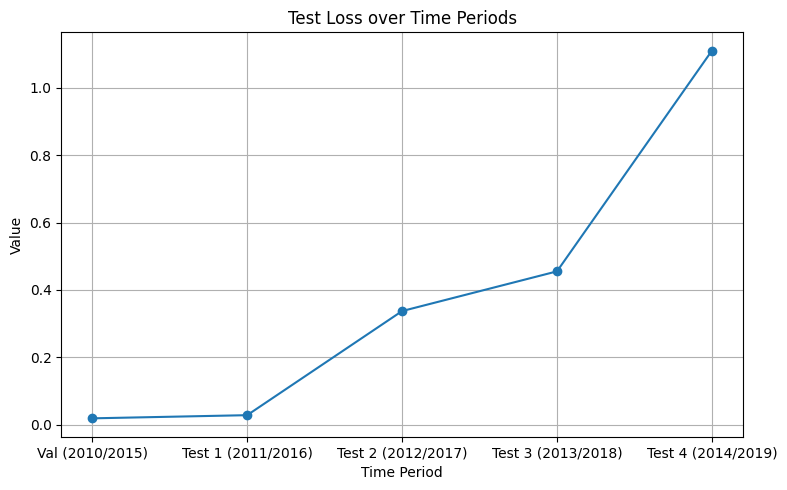

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Data
y = np.array([0.0184, 0.0278, 0.3371, 0.4551, 1.1106])
x_labels = ['Val (2010/2015)', 'Test 1 (2011/2016)', 'Test 2 (2012/2017)', 'Test 3 (2013/2018)', 'Test 4 (2014/2019)']

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x_labels, y, marker='o')
plt.xlabel('Time Period')
plt.ylabel('Value')
plt.title('Test Loss over Time Periods')
plt.grid(True)
plt.tight_layout()

plt.savefig('test_loss_over_time_periods.png', dpi=300)
plt.show()


# new train C1-C3 (MLE)

C:\Users\wanzh\AppData\Local\Temp\ipykernel_20752\3821724906.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_2010 = torch.load(f"output_rebuttal_mle_C1C2/2010_Gaus

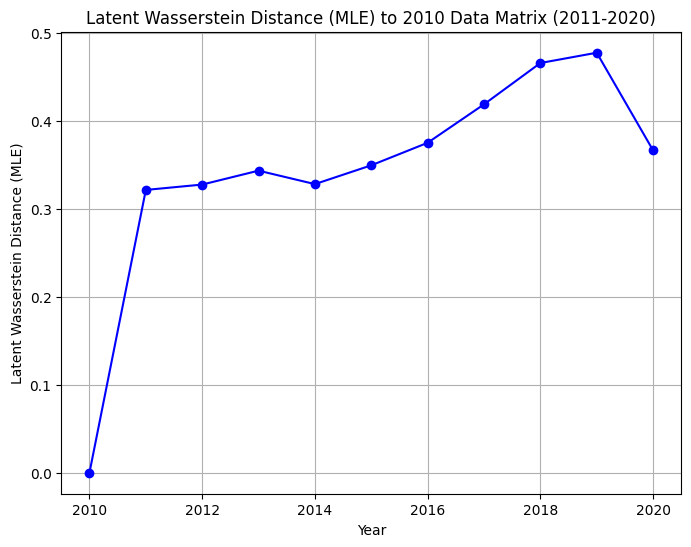

In [24]:
import torch
from scipy.stats import wasserstein_distance
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

variational_distribution = "Gaussian"       # Gaussian

# Load the 2010 data matrix (assuming it's a list of tensors)
data_2010 = torch.load(f"output_rebuttal_mle_C1C2/2010_Gaussian_all_mu.pt")

# Initialize a list to store the Wasserstein distances
wasserstein_distances = [0]

# Loop through the years 2011 to 2020 and calculate Wasserstein distance to 2010
for year in tqdm(range(2011, 2021)):
    # Load the data matrix for the year
    data_year = torch.load(f"output_rebuttal_mle_C1C2/{year}_Gaussian_all_mu.pt")
    
    num_nodes = min(data_year[-1].shape[0], data_2010[-1].shape[0])  # Compare only the smallest number of nodes
    # Extract the node feature matrices for the common nodes
    idx = np.random.choice(data_year[-1].shape[0], num_nodes, replace=False)
    feature_1 = data_year[-1][idx]  # Random
    feature_2 = data_2010[-1]  # Randomly selected features

    # Calculate Wasserstein distance and append to the list
    distance = sinkhorn_wasserstein2(feature_1, feature_2)
    wasserstein_distances.append(distance)

# Prepare data for plotting
years = np.arange(2010, 2021)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(years, wasserstein_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel(f'Latent Wasserstein Distance (MLE)')
plt.title(f'Latent Wasserstein Distance (MLE) to 2010 Data Matrix (2011-2020)')
plt.grid(True)
plt.show()


In [25]:
from scipy.stats import pearsonr, spearmanr

pearsonr(np.array(wasserstein_distances), np.arange(2010,2021)), spearmanr(np.array(wasserstein_distances), np.arange(2010,2021))

(PearsonRResult(statistic=np.float64(0.733482049167554), pvalue=np.float64(0.01020207195442651)),
 SignificanceResult(statistic=np.float64(0.9), pvalue=np.float64(0.00015997142806871369)))

C:\Users\wanzh\AppData\Local\Temp\ipykernel_20752\4014018670.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latent_position_2010 = torch.load(f"output_C3_new_0810_mle/2

Calculating Wasserstein distance for year 2011-2010...
0.4586249354094468
Calculating Wasserstein distance for year 2016-2015...
0.4578424011863867
Calculating Wasserstein distance for year 2012-2010...
0.33023119493006153
Calculating Wasserstein distance for year 2017-2015...
0.5089239525918944


d:\anaconda3\envs\rebuttal\Lib\site-packages\ot\bregman\_sinkhorn.py:632: RuntimeWarning: divide by zero encountered in divide
  u = 1.0 / nx.dot(Kp, v)
d:\anaconda3\envs\rebuttal\Lib\site-packages\ot\bregman\_sinkhorn.py:643: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn("Warning: numerical errors at iteration %d" % ii)
100%|██████████| 4/4 [00:00<00:00, 12.86it/s]


Calculating Wasserstein distance for year 2013-2010...
0.3680933406650251
Calculating Wasserstein distance for year 2018-2015...
0.104455516
Calculating Wasserstein distance for year 2014-2010...
0.5320185641807845
Calculating Wasserstein distance for year 2019-2015...
0.6262460198300579


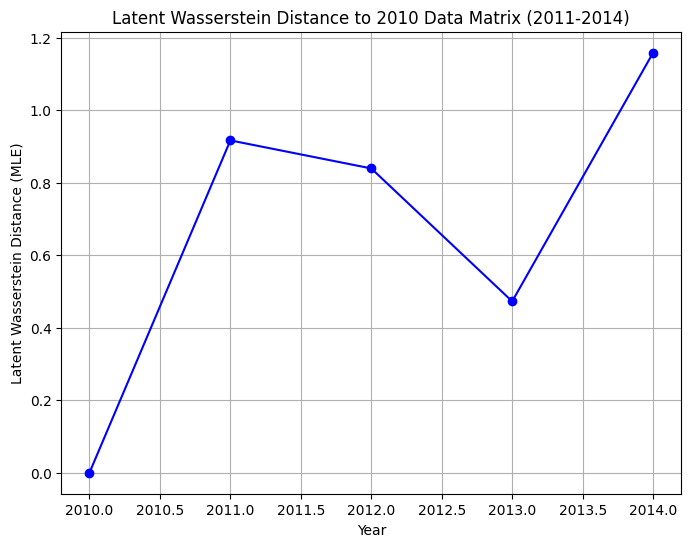

In [19]:
# Load the 2010 data matrix (assuming it's a list of tensors)
latent_position_2010 = torch.load(f"output_C3_new_0810_mle/2010_{variational_distribution}_2_all_mu.pt")[-1]
latent_position_2015 = torch.load(f"output_C3_new_0810_mle/2015_{variational_distribution}_2_all_mu.pt")[-1]

# Initialize a list to store the Wasserstein distances
wasserstein_distances = [0]

# Loop through the years 2011 to 2014 and calculate Wasserstein distance to 2010
for year in tqdm(range(2011, 2015)):
    # Load the data matrix for the year
    latent_position_year_0 = torch.load(f"output_C3_new_0810_mle/{year}_{variational_distribution}_2_all_mu.pt")[-1]
    latent_position_year_1 = torch.load(f"output_C3_new_0810_mle/{year+5}_{variational_distribution}_2_all_mu.pt")[-1]

    # Calculate Wasserstein distance and append to the list
    print(f"Calculating Wasserstein distance for year {year}-2010...")
    distance0 = sinkhorn_wasserstein2(latent_position_year_0, latent_position_2010)
    print(distance0)

    print(f"Calculating Wasserstein distance for year {year+5}-2015...")
    distance1 = sinkhorn_wasserstein2(latent_position_year_1, latent_position_2015)
    print(distance1)

    wasserstein_distances.append((distance0, distance1))

with open(f'output_C3_new_0810_mle/wasserstein_distances_{variational_distribution}.pkl', 'wb') as f:
    pickle.dump(wasserstein_distances, f)

# Prepare data for plotting
years = np.arange(2010, 2015)

wasserstein_distances = np.array([np.sum(wasserstein_distances[i]) for i in range(len(wasserstein_distances))])

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(years, wasserstein_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel(f'Latent Wasserstein Distance (MLE)')
plt.title(f'Latent Wasserstein Distance to 2010 Data Matrix (2011-2014)')
plt.grid(True)
plt.show()


In [21]:
from scipy.stats import pearsonr, spearmanr

empirical_losses = np.array([0.0184, 0.0278, 0.3371, 0.4551, 1.1106])

pearsonr(wasserstein_distances, empirical_losses), spearmanr(wasserstein_distances, empirical_losses)

(PearsonRResult(statistic=np.float64(0.6080686375717066), pvalue=np.float64(0.27656963643699867)),
 SignificanceResult(statistic=np.float64(0.6), pvalue=np.float64(0.28475697986529375)))

C:\Users\wanzh\AppData\Local\Temp\ipykernel_20752\4246994611.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latent_position_2010 = torch.load(f"output_rebuttal_mle_C1C2

Calculating Wasserstein distance for year 2011-2010...
0.3222948917257266
Calculating Wasserstein distance for year 2016-2015...


 25%|██▌       | 1/4 [02:53<08:39, 173.23s/it]

0.3065591266054802
Calculating Wasserstein distance for year 2012-2010...
0.3305899852224762
Calculating Wasserstein distance for year 2017-2015...


 50%|█████     | 2/4 [08:39<09:10, 275.14s/it]

0.32954410920206945
Calculating Wasserstein distance for year 2013-2010...
0.3453997052804579
Calculating Wasserstein distance for year 2018-2015...


d:\anaconda3\envs\rebuttal\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
 75%|███████▌  | 3/4 [17:11<06:23, 383.23s/it]

0.36823645161202845
Calculating Wasserstein distance for year 2014-2010...
0.3293614648588415
Calculating Wasserstein distance for year 2019-2015...


100%|██████████| 4/4 [18:55<00:00, 283.85s/it]

0.3740296877643262


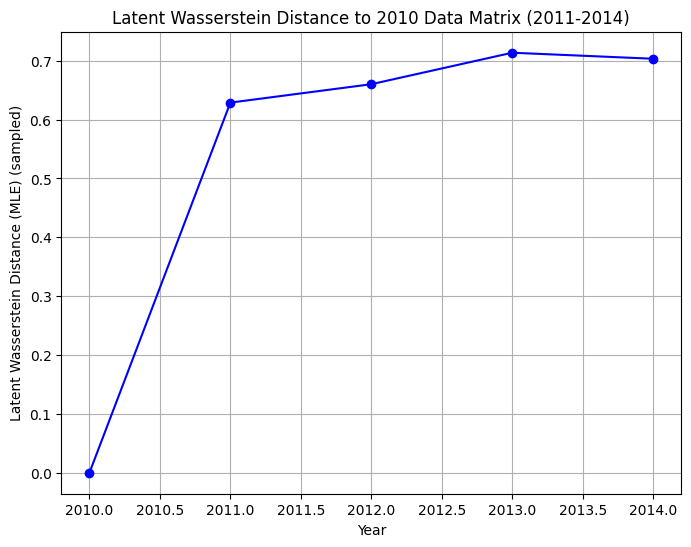

In [32]:
# Load the 2010 data matrix (assuming it's a list of tensors)
latent_position_2010 = torch.load(f"output_rebuttal_mle_C1C2/2010_{variational_distribution}_all_mu.pt")[-1]
latent_position_2015 = torch.load(f"output_rebuttal_mle_C1C2/2015_{variational_distribution}_all_mu.pt")[-1]

# Initialize a list to store the Wasserstein distances
wasserstein_distances = [0]

# Loop through the years 2011 to 2014 and calculate Wasserstein distance to 2010
for year in tqdm(range(2011, 2015)):
    # Load the data matrix for the year
    latent_position_year_0 = torch.load(f"output_rebuttal_mle_C1C2/{year}_{variational_distribution}_all_mu.pt")[-1]
    latent_position_year_1 = torch.load(f"output_rebuttal_mle_C1C2/{year+5}_{variational_distribution}_all_mu.pt")[-1]

    # Extract the node feature matrices for the common nodes
    min_nodes0 = min(latent_position_year_0.shape[0], latent_position_2010.shape[0])
    idx0 = np.random.choice(latent_position_year_0.shape[0], min_nodes0, replace=False)
    feature_0 = latent_position_year_0[idx0]  # Randomly selected features

    # Calculate Wasserstein distance and append to the list
    print(f"Calculating Wasserstein distance for year {year}-2010...")
    distance0 = sinkhorn_wasserstein2(feature_0, latent_position_2010)
    print(distance0)

    min_nodes1 = min(latent_position_year_1.shape[0], latent_position_2015.shape[0])
    idx1 = np.random.choice(latent_position_year_1.shape[0], min_nodes1, replace=False)
    feature_1 = latent_position_year_1[idx1]  # Randomly selected features

    print(f"Calculating Wasserstein distance for year {year+5}-2015...")
    distance1 = sinkhorn_wasserstein2(feature_1, latent_position_2015)
    print(distance1)

    wasserstein_distances.append((distance0, distance1))

with open(f'output_rebuttal_mle_C1C2/C3_wasserstein_distances_{variational_distribution}.pkl', 'wb') as f:
    pickle.dump(wasserstein_distances, f)

# Prepare data for plotting
years = np.arange(2010, 2015)

wasserstein_distances = np.array([np.sum(wasserstein_distances[i]) for i in range(len(wasserstein_distances))])

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(years, wasserstein_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel(f'Latent Wasserstein Distance (MLE) (sampled)')
plt.title(f'Latent Wasserstein Distance to 2010 Data Matrix (2011-2014)')
plt.grid(True)
plt.show()


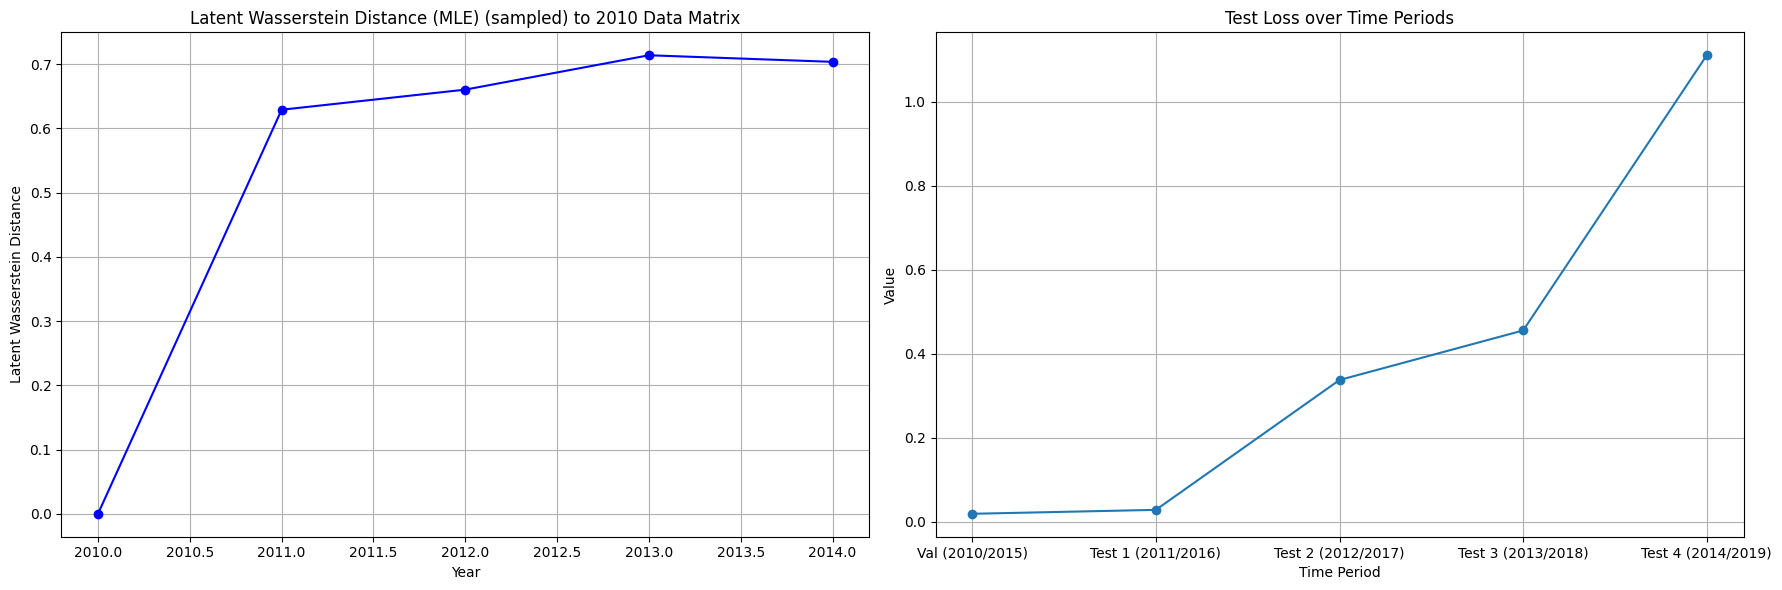

<Figure size 640x480 with 0 Axes>

In [45]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(years, wasserstein_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel(f'Latent Wasserstein Distance')
plt.title(f'Latent Wasserstein Distance (MLE) (sampled) to 2010 Data Matrix')
plt.grid(True)

# Data
y = np.array([0.0184, 0.0278, 0.3371, 0.4551, 1.1106])
x_labels = ['Val (2010/2015)', 'Test 1 (2011/2016)', 'Test 2 (2012/2017)', 'Test 3 (2013/2018)', 'Test 4 (2014/2019)']

# Plot
plt.subplot(1, 2, 2)
plt.plot(x_labels, y, marker='o')
plt.xlabel('Time Period')
plt.ylabel('Value')
plt.title('Test Loss over Time Periods')
plt.grid(True)
plt.tight_layout()

plt.show()
plt.savefig('wasserstein_and_test_loss.png', dpi=300)

In [42]:
from scipy.stats import pearsonr, spearmanr

empirical_losses = np.array([0.0184, 0.0278, 0.3371, 0.4551, 1.1106])

pearsonr(wasserstein_distances, empirical_losses), spearmanr(wasserstein_distances, empirical_losses)

(PearsonRResult(statistic=np.float64(0.5361132928718607), pvalue=np.float64(0.35167664276567134)),
 SignificanceResult(statistic=np.float64(0.8999999999999998), pvalue=np.float64(0.03738607346849874)))

## check $W(\hat{Z}_n,Z_N)$

100%|██████████| 36/36 [03:42<00:00,  6.17s/it]


ValueError: x and y must have same first dimension, but have shapes (149,) and (36,)

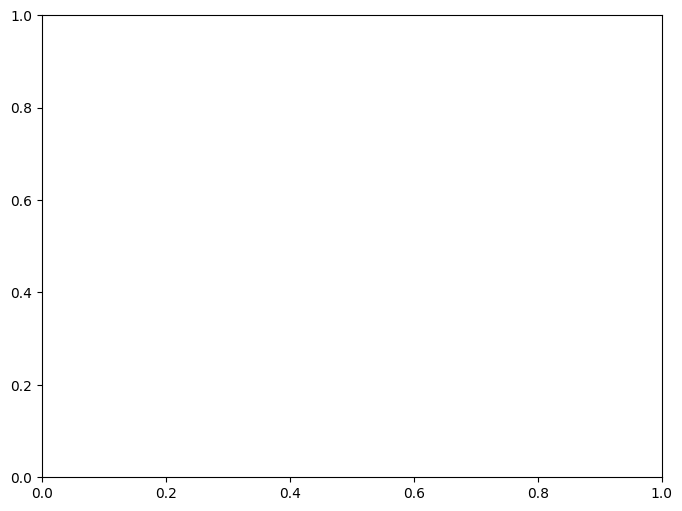

In [ ]:
ws = []

for n in tqdm(range(20, latent_position_2010.shape[0], 100)):
    sampled_latent_position_2010 = latent_position_2010[np.random.choice(latent_position_2010.shape[0], n, replace=False)]
    w = sinkhorn_wasserstein2(sampled_latent_position_2010, latent_position_2010)
    ws.append(w)

In [88]:
n = latent_position_2010.shape[0]

sampled_latent_position_2010 = latent_position_2010[np.random.choice(latent_position_2010.shape[0], n, replace=False)]
w_lastw = sinkhorn_wasserstein2(sampled_latent_position_2010, latent_position_2010)

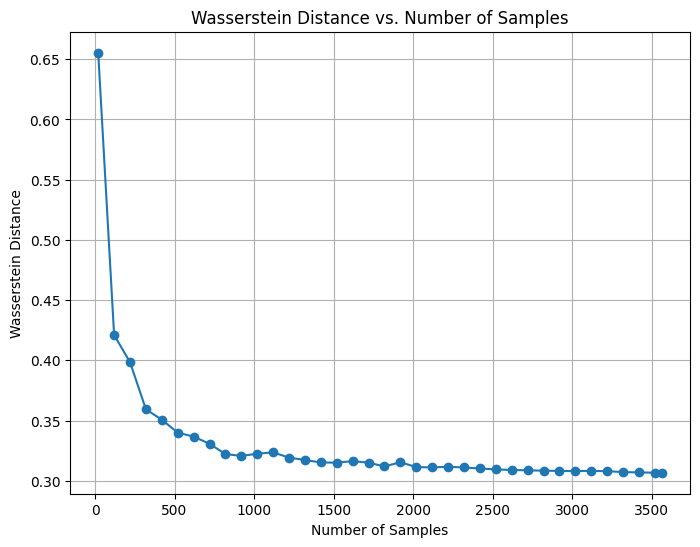

In [105]:
num_samples = list(range(20, latent_position_2010.shape[0], 100))
num_samples.append(latent_position_2010.shape[0])

plt.figure(figsize=(8, 6))
plt.plot(num_samples, ws+[w_lastw], marker='o')
plt.xlabel('Number of Samples')
plt.ylabel('Wasserstein Distance')
plt.title('Wasserstein Distance vs. Number of Samples')
plt.grid(True)
plt.show()

Text(0.5, 1.0, '$W_2$($P$,$\\hat{P}$)')

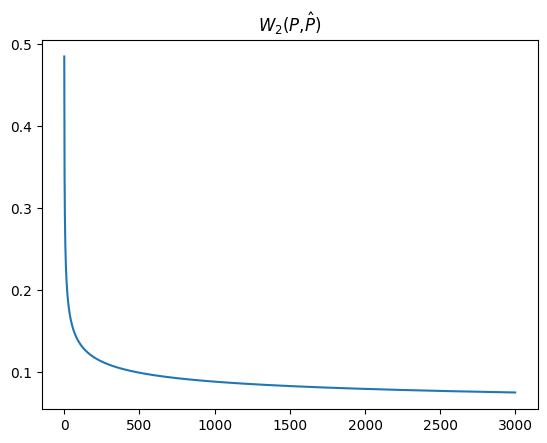

In [77]:
rho = 0.1           # probability of bound not to hold
B = 0.2             # diameter of space X
D_X = 2             # dimension of space X

plt.plot([B * (x**(-1/2)+(27**(-1/2)+np.log(1/rho)**(1/4)*x**(-1/4))) for x in range(1, 3000)])
plt.title('$W_2$($P$,$\hat{P}$)')

100%|██████████| 36/36 [00:33<00:00,  1.08it/s]


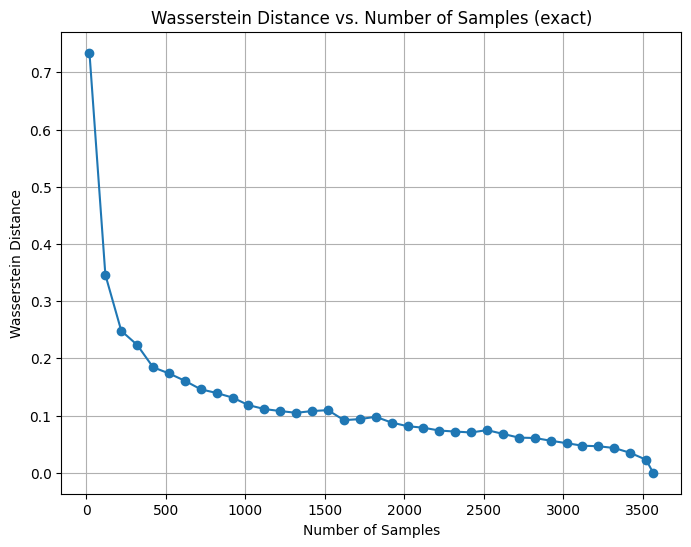

In [112]:
ws = []

for n in tqdm(range(20, latent_position_2010.shape[0], 100)):
    sampled_latent_position_2010 = latent_position_2010[np.random.choice(latent_position_2010.shape[0], n, replace=False)]
    w = exact_wasserstein2(sampled_latent_position_2010, latent_position_2010)
    ws.append(w)

n = latent_position_2010.shape[0]
sampled_latent_position_2010 = latent_position_2010[np.random.choice(latent_position_2010.shape[0], n, replace=False)]
w_lastw = exact_wasserstein2(sampled_latent_position_2010, latent_position_2010)

num_samples = list(range(20, latent_position_2010.shape[0], 100))
num_samples.append(latent_position_2010.shape[0])

plt.figure(figsize=(8, 6))
plt.plot(num_samples, ws+[w_lastw], marker='o')
plt.xlabel('Number of Samples')
plt.ylabel('Wasserstein Distance')
plt.title('Wasserstein Distance vs. Number of Samples (exact)')
plt.grid(True)
plt.show()

In [124]:
ws[-5:]

[np.float64(0.04733576941270565),
 np.float64(0.04642887608156316),
 np.float64(0.043322952217041535),
 np.float64(0.034882307603907384),
 np.float64(0.022844012743485496)]

In [123]:
w_lastw

np.float64(0.000125085681976785)

Text(0.5, 1.0, '$W_2$($P$,$\\hat{P}$)')

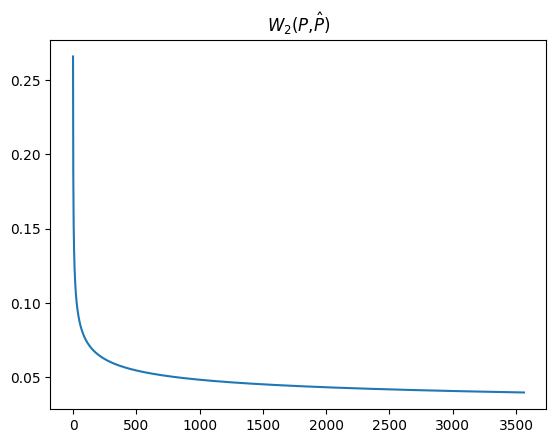

In [119]:
rho = 0.01           # probability of bound not to hold
B = 0.1             # diameter of space X
D_X = 2             # dimension of space X

plt.plot([B * (x**(-1/2)+(27**(-1/2)+np.log(1/rho)**(1/4)*x**(-1/4))) for x in range(1, 3565)])
plt.title('$W_2$($P$,$\hat{P}$)')

# new train C1-C3

C:\Users\wanzh\AppData\Local\Temp\ipykernel_47724\527598826.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latent_position_2010 = torch.load(f"output_C3/2010_{variatio

Calculating Wasserstein distance for year 2011-2010...
0.0002881201721294023
Calculating Wasserstein distance for year 2016-2015...
0.0006020372916792831
Calculating Wasserstein distance for year 2012-2010...
0.0006900935491641906
Calculating Wasserstein distance for year 2017-2015...
0.001791036078813635
Calculating Wasserstein distance for year 2013-2010...
0.000712792878086958
Calculating Wasserstein distance for year 2018-2015...
0.000640362656655021
Calculating Wasserstein distance for year 2014-2010...
0.0004803599992598483
Calculating Wasserstein distance for year 2019-2015...
0.000743319924871837


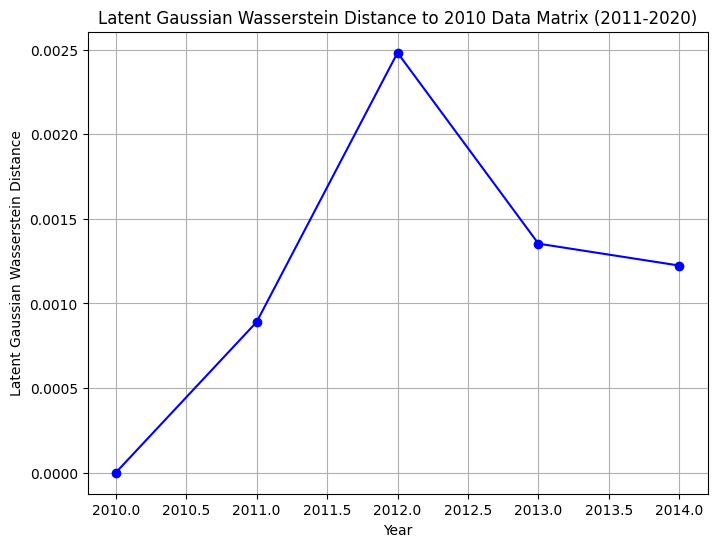

In [5]:
import torch
from scipy.stats import wasserstein_distance
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import ot
import pickle

def sinkhorn_wasserstein2(X, Y, reg=0.1):
    N = X.shape[0]
    a = b = np.ones(N) / N  # uniform weights
    M = ot.dist(X, Y, metric='euclidean') ** 2
    transport_plan = ot.sinkhorn(a, b, M, reg)
    return np.sqrt(np.sum(transport_plan * M))

variational_distribution = "Gaussian"       # Gaussian

# Load the 2010 data matrix (assuming it's a list of tensors)
latent_position_2010 = torch.load(f"output_C3/2010_{variational_distribution}_2_all_mu.pt")[-1]
latent_position_2015 = torch.load(f"output_C3/2015_{variational_distribution}_2_all_mu.pt")[-1]

# Initialize a list to store the Wasserstein distances
wasserstein_distances = [0]

# Loop through the years 2011 to 2014 and calculate Wasserstein distance to 2010
for year in tqdm(range(2011, 2015)):
    # Load the data matrix for the year
    latent_position_year_0 = torch.load(f"output_C3/{year}_{variational_distribution}_2_all_mu.pt")[-1]
    latent_position_year_1 = torch.load(f"output_C3/{year+5}_{variational_distribution}_2_all_mu.pt")[-1]

    # Calculate Wasserstein distance and append to the list
    print(f"Calculating Wasserstein distance for year {year}-2010...")
    distance0 = sinkhorn_wasserstein2(latent_position_year_0, latent_position_2010)
    print(distance0)

    print(f"Calculating Wasserstein distance for year {year+5}-2015...")
    distance1 = sinkhorn_wasserstein2(latent_position_year_1, latent_position_2015)
    print(distance1)

    wasserstein_distances.append((distance0, distance1))

with open(f'output_C3/wasserstein_distances_{variational_distribution}.pkl', 'wb') as f:
    pickle.dump(wasserstein_distances, f)

# Prepare data for plotting
years = np.arange(2010, 2015)

wasserstein_distances = np.array([np.sum(wasserstein_distances[i]) for i in range(len(wasserstein_distances))])

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(years, wasserstein_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel(f'Latent Gaussian Wasserstein Distance')
plt.title(f'Latent Gaussian Wasserstein Distance to 2010 Data Matrix (2011-2020)')
plt.grid(True)
plt.show()


In [4]:
from scipy.stats import pearsonr, spearmanr

empirical_losses = np.array([0.0184, 0.0278, 0.3371, 0.4551, 1.1106])

pearsonr(wasserstein_distances, empirical_losses), spearmanr(wasserstein_distances, empirical_losses)

(PearsonRResult(statistic=np.float64(0.081852474290601), pvalue=np.float64(0.8958986836877869)),
 SignificanceResult(statistic=np.float64(0.8999999999999998), pvalue=np.float64(0.03738607346849874)))

C:\Users\wanzh\AppData\Local\Temp\ipykernel_47724\329883188.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_2010 = torch.load(f"output_rebuttal/2010_Gaussian_all_m

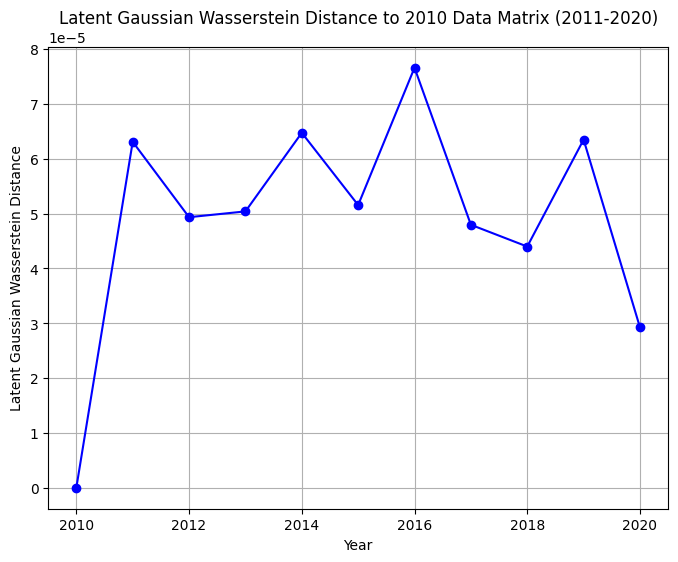

In [7]:
import torch
from scipy.stats import wasserstein_distance
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

variational_distribution = "Gaussian"       # Gaussian

# Load the 2010 data matrix (assuming it's a list of tensors)
data_2010 = torch.load(f"output_rebuttal/2010_Gaussian_all_mu.pt")

# Initialize a list to store the Wasserstein distances
wasserstein_distances = [0]

# Loop through the years 2011 to 2020 and calculate Wasserstein distance to 2010
for year in tqdm(range(2011, 2021)):
    # Load the data matrix for the year
    data_year = torch.load(f"output_rebuttal/{year}_Gaussian_all_mu.pt")
    
    num_nodes = min(data_year[-1].shape[0], data_2010[-1].shape[0])  # Compare only the smallest number of nodes
    # Extract the node feature matrices for the common nodes
    idx = np.random.choice(data_year[-1].shape[0], num_nodes, replace=False)
    feature_1 = data_year[-1][idx]  # Random
    feature_2 = data_2010[-1]  # Randomly selected features

    # Calculate Wasserstein distance and append to the list
    distance = sinkhorn_wasserstein2(feature_1, feature_2)
    wasserstein_distances.append(distance)

# Prepare data for plotting
years = np.arange(2010, 2021)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(years, wasserstein_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel(f'Latent Gaussian Wasserstein Distance')
plt.title(f'Latent Gaussian Wasserstein Distance to 2010 Data Matrix (2011-2020)')
plt.grid(True)
plt.show()


In [9]:
from scipy.stats import pearsonr, spearmanr

# empirical_losses = np.array([0.0184, 0.0278, 0.3371, 0.4551, 1.1106])

# pearsonr(wasserstein_distances, empirical_losses), spearmanr(wasserstein_distances, empirical_losses)

pearsonr(wasserstein_distances, np.arange(2010,2021)), spearmanr(wasserstein_distances, np.arange(2010,2021))

(PearsonRResult(statistic=np.float64(0.20300489521009116), pvalue=np.float64(0.5493942030292954)),
 SignificanceResult(statistic=np.float64(0.0), pvalue=np.float64(1.0)))

# new train C3

In [15]:
import pickle

file_path = 'preprocessed_data/train_val_graphs_2010_2015.pkl'

# Load the data from the pickle file
with open(file_path, 'rb') as f:
    train_val_graphs, train_val_labels = pickle.load(f)

# Now you can use the loaded data
print(f"Loaded {len(train_val_graphs)} training graphs.")
print(np.unique(train_val_labels, return_counts=True))

Loaded 400 training graphs.
(array([0, 1]), array([200, 200]))


In [11]:
idx_0 = [idx for idx, label in enumerate(train_val_labels) if label == 0]
idx_1 = [idx for idx, label in enumerate(train_val_labels) if label == 1]

train_val_graphs_0 = [train_val_graphs[idx] for idx in idx_0]
train_val_graphs_1 = [train_val_graphs[idx] for idx in idx_1]

In [13]:
train_val_graphs_1

[Data(num_nodes=100, edge_index=[2, 0], x=[100, 128], node_year=[100, 1], y=[100, 1]),
 Data(num_nodes=100, edge_index=[2, 1], x=[100, 128], node_year=[100, 1], y=[100, 1]),
 Data(num_nodes=100, edge_index=[2, 0], x=[100, 128], node_year=[100, 1], y=[100, 1]),
 Data(num_nodes=100, edge_index=[2, 0], x=[100, 128], node_year=[100, 1], y=[100, 1]),
 Data(num_nodes=100, edge_index=[2, 0], x=[100, 128], node_year=[100, 1], y=[100, 1]),
 Data(num_nodes=100, edge_index=[2, 0], x=[100, 128], node_year=[100, 1], y=[100, 1]),
 Data(num_nodes=100, edge_index=[2, 0], x=[100, 128], node_year=[100, 1], y=[100, 1]),
 Data(num_nodes=100, edge_index=[2, 0], x=[100, 128], node_year=[100, 1], y=[100, 1]),
 Data(num_nodes=100, edge_index=[2, 0], x=[100, 128], node_year=[100, 1], y=[100, 1]),
 Data(num_nodes=100, edge_index=[2, 2], x=[100, 128], node_year=[100, 1], y=[100, 1]),
 Data(num_nodes=100, edge_index=[2, 1], x=[100, 128], node_year=[100, 1], y=[100, 1]),
 Data(num_nodes=100, edge_index=[2, 0], x=[

In [34]:
avg = 0

for i in range(len(train_val_graphs_0)):
    avg += train_val_graphs_0[i].edge_index.shape[1]
avg /= len(train_val_graphs_0)
print(f"Average number of edges in test graphs with label 0: {avg}")

avg = 0

for i in range(len(train_val_graphs_1)):
    avg += train_val_graphs_1[i].edge_index.shape[1]
avg /= len(train_val_graphs_1)
print(f"Average number of edges in test graphs with label 1: {avg}")

Average number of edges in test graphs with label 0: 1.05
Average number of edges in test graphs with label 1: 0.58


In [49]:
file_path = 'preprocessed_data/test_graphs_2012_2017.pkl'

# Load the data from the pickle file
with open(file_path, 'rb') as f:
    test_graphs, test_labels = pickle.load(f)

# Now you can use the loaded data
print(f"Loaded {len(test_graphs)} testing graphs.")
print(np.unique(test_labels, return_counts=True))

Loaded 400 testing graphs.
(array([0, 1]), array([200, 200]))


In [50]:
idx_0 = [idx for idx, label in enumerate(test_labels) if label == 0]
idx_1 = [idx for idx, label in enumerate(test_labels) if label == 1]

test_graphs_0 = [test_graphs[idx] for idx in idx_0]
test_graphs_1 = [test_graphs[idx] for idx in idx_1]

In [51]:
avg = 0

for i in range(len(test_graphs_0)):
    avg += test_graphs_0[i].edge_index.shape[1]
avg /= len(test_graphs_0)
print(f"Average number of edges in test graphs with label 0: {avg}")

avg = 0

for i in range(len(test_graphs_1)):
    avg += test_graphs_1[i].edge_index.shape[1]
avg /= len(test_graphs_1)
print(f"Average number of edges in test graphs with label 1: {avg}")

Average number of edges in test graphs with label 0: 0.645
Average number of edges in test graphs with label 1: 0.445


train 2010-2015: 1.05-0.58
test  2011-2016: 0.93-0.565
test  2012-2017: 0.645-0.445
test  2013-2018: 0.785-0.32
test  2014-2019: 0.755-0.24

train loss: 0.0059      val loss: 0.0184        train acc: 0.9938      val acc: 1.0000
test loss:  0.0278      test acc: 0.9925
test loss:  0.3371      test acc: 0.8625
tets loss:  0.4551      test acc: 0.7900
test loss:  1.1106      test acc: 0.6350

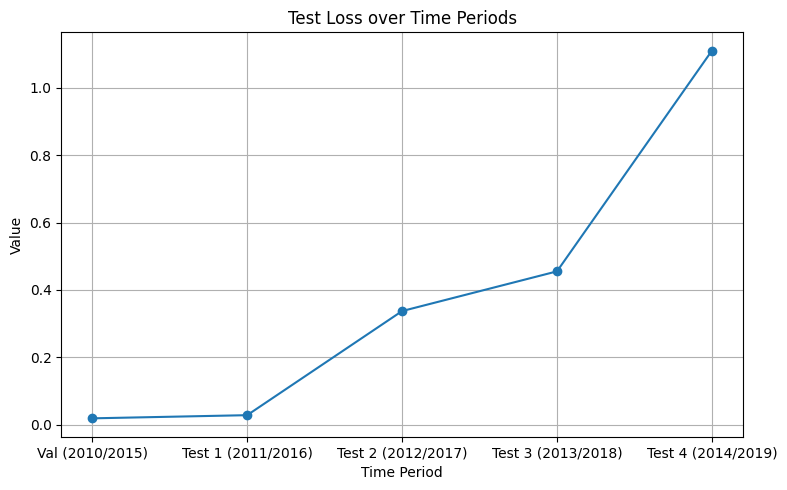

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Data
y = np.array([0.0184, 0.0278, 0.3371, 0.4551, 1.1106])
x_labels = ['Val (2010/2015)', 'Test 1 (2011/2016)', 'Test 2 (2012/2017)', 'Test 3 (2013/2018)', 'Test 4 (2014/2019)']

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x_labels, y, marker='o')
plt.xlabel('Time Period')
plt.ylabel('Value')
plt.title('Test Loss over Time Periods')
plt.grid(True)
plt.tight_layout()

plt.savefig('test_loss_over_time_periods.png', dpi=300)
plt.show()


C:\Users\wanzh\AppData\Local\Temp\ipykernel_25472\169869079.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latent_position_2010 = torch.load(f"output_C3/2010_{variatio

Calculating Wasserstein distance for year 2011-2010...
0.0002881201721294023
Calculating Wasserstein distance for year 2016-2015...
0.0006020372916792831
Calculating Wasserstein distance for year 2012-2010...
0.0006900935491641906
Calculating Wasserstein distance for year 2017-2015...
0.001791036078813635
Calculating Wasserstein distance for year 2013-2010...
0.000712792878086958
Calculating Wasserstein distance for year 2018-2015...
0.000640362656655021
Calculating Wasserstein distance for year 2014-2010...
0.0004803599992598483
Calculating Wasserstein distance for year 2019-2015...
0.000743319924871837


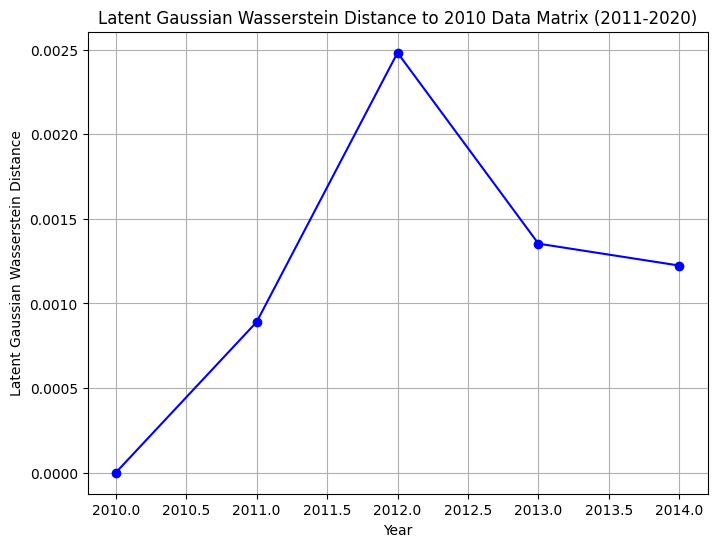

In [116]:
import torch
from scipy.stats import wasserstein_distance
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import ot

def sinkhorn_wasserstein2(X, Y, reg=0.1):
    N = X.shape[0]
    a = b = np.ones(N) / N  # uniform weights
    M = ot.dist(X, Y, metric='euclidean') ** 2
    transport_plan = ot.sinkhorn(a, b, M, reg)
    return np.sqrt(np.sum(transport_plan * M))

variational_distribution = "Gaussian"       # Gaussian

# Load the 2010 data matrix (assuming it's a list of tensors)
latent_position_2010 = torch.load(f"output_C3/2010_{variational_distribution}_2_all_mu.pt")[-1]
latent_position_2015 = torch.load(f"output_C3/2015_{variational_distribution}_2_all_mu.pt")[-1]

# Initialize a list to store the Wasserstein distances
wasserstein_distances = [0]

# Loop through the years 2011 to 2014 and calculate Wasserstein distance to 2010
for year in tqdm(range(2011, 2015)):
    # Load the data matrix for the year
    latent_position_year_0 = torch.load(f"output_C3/{year}_{variational_distribution}_2_all_mu.pt")[-1]
    latent_position_year_1 = torch.load(f"output_C3/{year+5}_{variational_distribution}_2_all_mu.pt")[-1]

    # Calculate Wasserstein distance and append to the list
    print(f"Calculating Wasserstein distance for year {year}-2010...")
    distance0 = sinkhorn_wasserstein2(latent_position_year_0, latent_position_2010)
    print(distance0)

    print(f"Calculating Wasserstein distance for year {year+5}-2015...")
    distance1 = sinkhorn_wasserstein2(latent_position_year_1, latent_position_2015)
    print(distance1)

    wasserstein_distances.append((distance0, distance1))

with open(f'output_C3/wasserstein_distances_{variational_distribution}.pkl', 'wb') as f:
    pickle.dump(wasserstein_distances, f)

# Prepare data for plotting
years = np.arange(2010, 2015)

wasserstein_distances = np.array([np.sum(wasserstein_distances[i]) for i in range(len(wasserstein_distances))])

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(years, wasserstein_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel(f'Latent Gaussian Wasserstein Distance')
plt.title(f'Latent Gaussian Wasserstein Distance to 2010 Data Matrix (2011-2020)')
plt.grid(True)
plt.show()


In [117]:
wasserstein_distances

array([0.        , 0.00089016, 0.00248113, 0.00135316, 0.00122368])

In [118]:
from scipy.stats import pearsonr, spearmanr

empirical_losses = np.array([0.0184, 0.0278, 0.3371, 0.4551, 1.1106])

pearsonr(wasserstein_distances, empirical_losses), spearmanr(wasserstein_distances, empirical_losses)

(PearsonRResult(statistic=np.float64(0.3242317481314418), pvalue=np.float64(0.5945270073248148)),
 SignificanceResult(statistic=np.float64(0.6), pvalue=np.float64(0.28475697986529375)))

C:\Users\wanzh\AppData\Local\Temp\ipykernel_25472\659402340.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latent_position_2010 = torch.load(f"output_C3/2010_{variatio

Calculating Wasserstein distance for year 2011-2010...
0.5325552722255533
Calculating Wasserstein distance for year 2016-2015...
0.37828000860146205
Calculating Wasserstein distance for year 2012-2010...
0.5707942080649046
Calculating Wasserstein distance for year 2017-2015...
0.43323720599843524
Calculating Wasserstein distance for year 2013-2010...
0.4272666860105451
Calculating Wasserstein distance for year 2018-2015...


100%|██████████| 4/4 [00:00<00:00, 14.52it/s]

0.5294477048954714
Calculating Wasserstein distance for year 2014-2010...
0.603607738042338
Calculating Wasserstein distance for year 2019-2015...
0.767862757491147


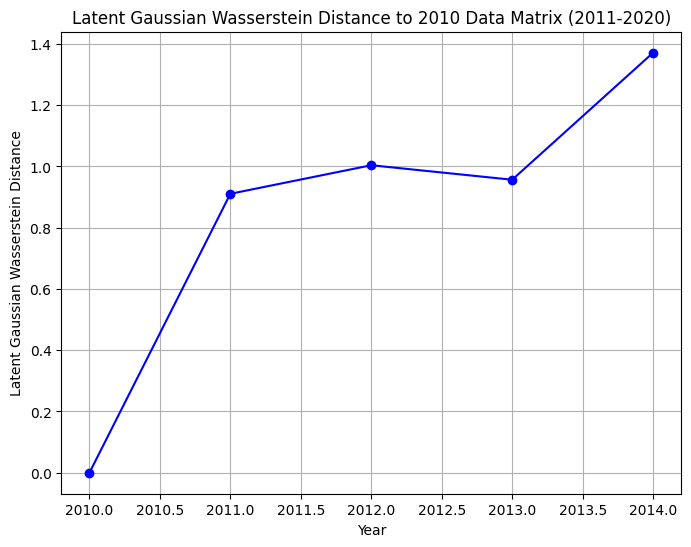

In [119]:
import torch
from scipy.stats import wasserstein_distance
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import ot

def sinkhorn_wasserstein2(X, Y, reg=0.1):
    N = X.shape[0]
    a = b = np.ones(N) / N  # uniform weights
    M = ot.dist(X, Y, metric='euclidean') ** 2
    transport_plan = ot.sinkhorn(a, b, M, reg)
    return np.sqrt(np.sum(transport_plan * M))

variational_distribution = "Laplace"       # Gaussian

# Load the 2010 data matrix (assuming it's a list of tensors)
latent_position_2010 = torch.load(f"output_C3/2010_{variational_distribution}_2_all_mu.pt")[-1]
latent_position_2015 = torch.load(f"output_C3/2015_{variational_distribution}_2_all_mu.pt")[-1]

# Initialize a list to store the Wasserstein distances
wasserstein_distances = [0]

# Loop through the years 2011 to 2014 and calculate Wasserstein distance to 2010
for year in tqdm(range(2011, 2015)):
    # Load the data matrix for the year
    latent_position_year_0 = torch.load(f"output_C3/{year}_{variational_distribution}_2_all_mu.pt")[-1]
    latent_position_year_1 = torch.load(f"output_C3/{year+5}_{variational_distribution}_2_all_mu.pt")[-1]

    # Calculate Wasserstein distance and append to the list
    print(f"Calculating Wasserstein distance for year {year}-2010...")
    distance0 = sinkhorn_wasserstein2(latent_position_year_0, latent_position_2010)
    print(distance0)

    print(f"Calculating Wasserstein distance for year {year+5}-2015...")
    distance1 = sinkhorn_wasserstein2(latent_position_year_1, latent_position_2015)
    print(distance1)

    wasserstein_distances.append((distance0, distance1))

with open(f'output_C3/wasserstein_distances_{variational_distribution}.pkl', 'wb') as f:
    pickle.dump(wasserstein_distances, f)

# Prepare data for plotting
years = np.arange(2010, 2015)

wasserstein_distances = np.array([np.sum(wasserstein_distances[i]) for i in range(len(wasserstein_distances))])

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(years, wasserstein_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel(f'Latent Gaussian Wasserstein Distance')
plt.title(f'Latent Gaussian Wasserstein Distance to 2010 Data Matrix (2011-2020)')
plt.grid(True)
plt.show()


In [120]:
wasserstein_distances

array([0.        , 0.91083528, 1.00403141, 0.95671439, 1.3714705 ])

In [121]:
from scipy.stats import pearsonr, spearmanr

empirical_losses = np.array([0.0184, 0.0278, 0.3371, 0.4551, 1.1106])

pearsonr(wasserstein_distances, empirical_losses), spearmanr(wasserstein_distances, empirical_losses)

(PearsonRResult(statistic=np.float64(0.737211711183224), pvalue=np.float64(0.15518005463543952)),
 SignificanceResult(statistic=np.float64(0.8999999999999998), pvalue=np.float64(0.03738607346849874)))

C:\Users\wanzh\AppData\Local\Temp\ipykernel_25472\2363114253.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latent_position_2010 = torch.load(f"output_C3/2010_{variati

Calculating Wasserstein distance for year 2011-2010...
0.879600961360074
Calculating Wasserstein distance for year 2016-2015...
0.4898366799367793
Calculating Wasserstein distance for year 2012-2010...
0.8101190011885872
Calculating Wasserstein distance for year 2017-2015...
0.45950512331518817
Calculating Wasserstein distance for year 2013-2010...
0.868051501958275
Calculating Wasserstein distance for year 2018-2015...
0.5619966510404759
Calculating Wasserstein distance for year 2014-2010...
0.7746711962131948
Calculating Wasserstein distance for year 2019-2015...


100%|██████████| 4/4 [00:00<00:00, 17.36it/s]

0.6372356045470174


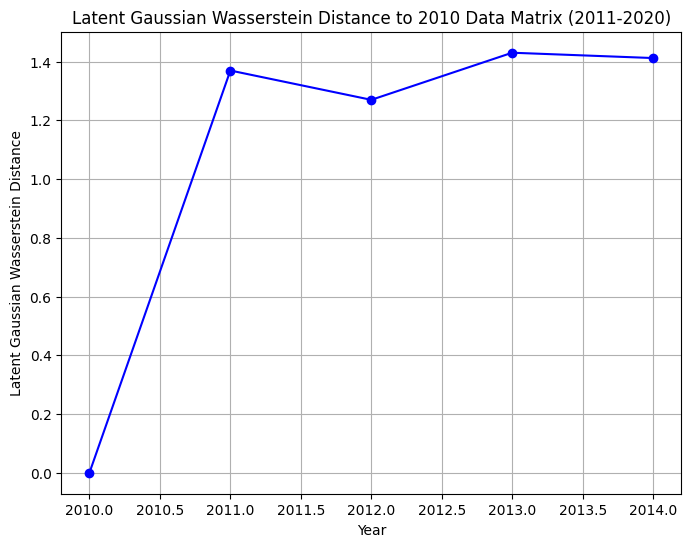

In [122]:
import torch
from scipy.stats import wasserstein_distance
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import ot

def sinkhorn_wasserstein2(X, Y, reg=0.1):
    N = X.shape[0]
    a = b = np.ones(N) / N  # uniform weights
    M = ot.dist(X, Y, metric='euclidean') ** 2
    transport_plan = ot.sinkhorn(a, b, M, reg)
    return np.sqrt(np.sum(transport_plan * M))

variational_distribution = "MoG"       # Gaussian

# Load the 2010 data matrix (assuming it's a list of tensors)
latent_position_2010 = torch.load(f"output_C3/2010_{variational_distribution}_2_all_mu.pt")[-1]
latent_position_2015 = torch.load(f"output_C3/2015_{variational_distribution}_2_all_mu.pt")[-1]

# Initialize a list to store the Wasserstein distances
wasserstein_distances = [0]

# Loop through the years 2011 to 2014 and calculate Wasserstein distance to 2010
for year in tqdm(range(2011, 2015)):
    # Load the data matrix for the year
    latent_position_year_0 = torch.load(f"output_C3/{year}_{variational_distribution}_2_all_mu.pt")[-1]
    latent_position_year_1 = torch.load(f"output_C3/{year+5}_{variational_distribution}_2_all_mu.pt")[-1]

    # Calculate Wasserstein distance and append to the list
    print(f"Calculating Wasserstein distance for year {year}-2010...")
    distance0 = sinkhorn_wasserstein2(latent_position_year_0, latent_position_2010)
    print(distance0)

    print(f"Calculating Wasserstein distance for year {year+5}-2015...")
    distance1 = sinkhorn_wasserstein2(latent_position_year_1, latent_position_2015)
    print(distance1)

    wasserstein_distances.append((distance0, distance1))

with open(f'output_C3/wasserstein_distances_{variational_distribution}.pkl', 'wb') as f:
    pickle.dump(wasserstein_distances, f)

# Prepare data for plotting
years = np.arange(2010, 2015)

wasserstein_distances = np.array([np.sum(wasserstein_distances[i]) for i in range(len(wasserstein_distances))])

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(years, wasserstein_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel(f'Latent Gaussian Wasserstein Distance')
plt.title(f'Latent Gaussian Wasserstein Distance to 2010 Data Matrix (2011-2020)')
plt.grid(True)
plt.show()


In [124]:
wasserstein_distances

array([0.        , 1.36943764, 1.26962412, 1.43004815, 1.4119068 ])

In [123]:
from scipy.stats import pearsonr, spearmanr

empirical_losses = np.array([0.0184, 0.0278, 0.3371, 0.4551, 1.1106])

pearsonr(wasserstein_distances, empirical_losses), spearmanr(wasserstein_distances, empirical_losses)

(PearsonRResult(statistic=np.float64(0.49913845091874903), pvalue=np.float64(0.39195248537566035)),
 SignificanceResult(statistic=np.float64(0.7999999999999999), pvalue=np.float64(0.10408803866182788)))

In [98]:
import matplotlib.pyplot as plt
from torch_geometric.utils import to_scipy_sparse_matrix
from scipy.sparse.csgraph import shortest_path
import numpy as np
import ot

def gw_dist(A1, A2):
    C1 = A1  # adjacency or distance matrix of G1
    C2 = A2  # adjacency or distance matrix of G2
    p = ot.unif(C1.shape[0])
    q = ot.unif(C2.shape[0])

    gw_dist = ot.gromov.gromov_wasserstein2(C1, C2, p, q, 'square_loss')
    print(f"Gromov-Wasserstein distance: {gw_dist}")

    return gw_dist


# Load the subgraphs for year 2010
sub_data_2010 = torch.load('./dataset/ogbn_arxiv/processed/subgraph_2010.pt')

wasserstein_distances = [0]

# Loop through the years from 2011 to 2020
for year in range(2011, 2021):
    # Load the subgraph for the current year
    sub_data_X = torch.load(f'./dataset/ogbn_arxiv/processed/subgraph_{year}.pt')
    
    # Compute the Wasserstein distance between year X and year 2010
    # wasserstein_dist = sinkhorn_wasserstein2(sub_data_X., sub_data_2010)

    A1 = to_scipy_sparse_matrix(sub_data_X.edge_index, num_nodes=sub_data_X.num_nodes).astype(np.float64)
    A2 = to_scipy_sparse_matrix(sub_data_2010.edge_index, num_nodes=sub_data_2010.num_nodes).astype(np.float64)

    # Step 1: Convert to dense adjacency or shortest-path matrices
    A1_dense = A1.toarray()
    A2_dense = A2.toarray()

    # Optional: convert to shortest-path distance matrices
    # If graphs are not fully connected, consider adding a small epsilon or using all-pairs shortest path

    D1 = shortest_path(A1, directed=False, unweighted=True)
    D2 = shortest_path(A2, directed=False, unweighted=True)

    # Step 2: Normalize distributions over nodes (uniform)
    n1, n2 = D1.shape[0], D2.shape[0]
    p = np.ones(n1) / n1  # Uniform measure over G1
    q = np.ones(n2) / n2  # Uniform measure over G2

    # Step 3: Compute Gromov-Wasserstein distance
    gw_distance = ot.gromov.gromov_wasserstein2(D1, D2, p, q, 'square_loss')
    
    # Print the computed Wasserstein distance
    print(f"Wasserstein Distance between node attributes of {year} and 2010: {gw_distance}")

    wasserstein_distances.append(gw_distance)

# Prepare data for plotting
years = np.arange(2010, 2021)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(years, wasserstein_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Observed Wasserstein Distance')
plt.title('Observed Wasserstein Distance to 2010 Data Matrix (2011-2020)')
plt.grid(True)
plt.show()

C:\Users\wanzh\AppData\Local\Temp\ipykernel_25472\3297155271.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sub_data_2010 = torch.load('./dataset/ogbn_arxiv/processed/

KeyboardInterrupt: 

# old

In [2]:
# Load dataset
dataset = PygNodePropPredDataset(name='ogbn-arxiv')
data = dataset[0]  # PyG graph object
split_idx = dataset.get_idx_split()

# Access year information
years = data.node_year.squeeze()  # shape: [N]

# Group node indices by year
year_to_indices = defaultdict(list)
for idx, year in enumerate(years.tolist()):
    year_to_indices[year].append(idx)

# Convert to tensors and print sizes
year_split_dict = {year: torch.tensor(indices, dtype=torch.long) 
                   for year, indices in year_to_indices.items()}

print("Available publish years:", sorted(year_split_dict.keys()))
for year, indices in sorted(year_split_dict.items()):
    print(f"Year {year}: {len(indices)} nodes")

# Example: get subgraph for a specific year
year = 2010
selected_nodes = year_split_dict[year]
print(f"\nNodes from year {year}: {selected_nodes[:10]}")


d:\anaconda3\envs\rebuttal\Lib\site-packages\ogb\nodeproppred\dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.proce

Available publish years: [1971, 1986, 1987, 1988, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Year 1971: 1 nodes
Year 1986: 1 nodes
Year 1987: 1 nodes
Year 1988: 1 nodes
Year 1990: 3 nodes
Year 1991: 3 nodes
Year 1992: 1 nodes
Year 1993: 8 nodes
Year 1994: 19 nodes
Year 1995: 25 nodes
Year 1996: 31 nodes
Year 1997: 33 nodes
Year 1998: 123 nodes
Year 1999: 165 nodes
Year 2000: 261 nodes
Year 2001: 248 nodes
Year 2002: 355 nodes
Year 2003: 387 nodes
Year 2004: 415 nodes
Year 2005: 629 nodes
Year 2006: 968 nodes
Year 2007: 1302 nodes
Year 2008: 1931 nodes
Year 2009: 2499 nodes
Year 2010: 3564 nodes
Year 2011: 4427 nodes
Year 2012: 6435 nodes
Year 2013: 8135 nodes
Year 2014: 9154 nodes
Year 2015: 12035 nodes
Year 2016: 16339 nodes
Year 2017: 21442 nodes
Year 2018: 29799 nodes
Year 2019: 39711 nodes
Year 2020: 8892 nodes

Nodes from year 2010: tensor(

In [3]:
from torch_geometric.utils import subgraph

def get_subgraph_by_year(data, target_year):
    years = data.node_year.squeeze()
    node_mask = (years == target_year)
    selected_nodes = node_mask.nonzero(as_tuple=True)[0]

    if selected_nodes.numel() == 0:
        raise ValueError(f"No nodes found for year {target_year}.")

    # Relabel nodes in the edge_index to range 0..len(selected_nodes)-1
    sub_edge_index, _ = subgraph(selected_nodes, data.edge_index, relabel_nodes=True)

    # Build subgraph data object
    sub_data = data.clone()
    sub_data.edge_index = sub_edge_index
    sub_data.x = data.x[selected_nodes]
    sub_data.y = data.y[selected_nodes]
    sub_data.node_year = data.node_year[selected_nodes]
    sub_data.num_nodes = selected_nodes.size(0)  # <-- Fix: correct graph size

    return sub_data


In [4]:
from ogb.nodeproppred import PygNodePropPredDataset

# Load the ogbn-arxiv dataset
dataset = PygNodePropPredDataset(name='ogbn-arxiv')
data = dataset[0]

# Get subgraph for year 2015
sub_data = get_subgraph_by_year(data, target_year=2015)

print(f"Year 2015 subgraph:")
print(f"- Nodes: {sub_data.num_nodes}")
print(f"- Edges: {sub_data.edge_index.size(1)}")

Year 2015 subgraph:
- Nodes: 12035
- Edges: 8125


d:\anaconda3\envs\rebuttal\Lib\site-packages\ogb\nodeproppred\dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.proce

Year 2010 subgraph:
- Nodes: 3564
- Edges: 1546


(array([ 20.,  15., 240.,  28., 120., 128.,  13.,  17., 210., 146., 189.,
         18.,   2.,  28.,  37.,  11.,  87.,  12.,   1.,   7.,  80.,  20.,
         66.,  66., 146.,   4.,  28.,  24., 940.,  13.,  45.,  49.,  12.,
         73., 298.,  10., 147.,  51., 163.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39.]),
 <BarContainer object of 39 artists>)

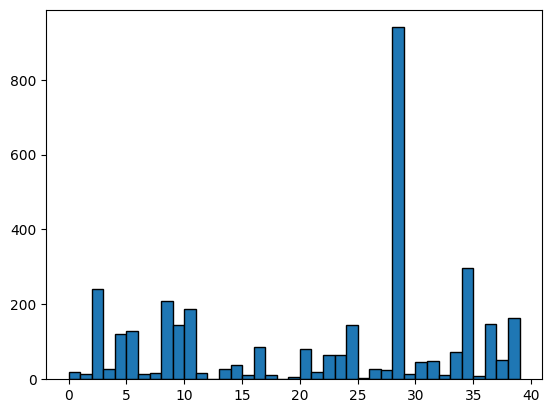

In [5]:
import matplotlib.pyplot as plt

year = 2010

sub_data = get_subgraph_by_year(data, target_year=year)
print(f"Year {year} subgraph:")
print(f"- Nodes: {sub_data.num_nodes}")
print(f"- Edges: {sub_data.edge_index.size(1)}")

plt.hist(sub_data.y,bins=np.arange(0, 40), edgecolor='black')

In [43]:
np.count_nonzero(sub_data.y == 28)

940

In [45]:
(3564-940)/940

2.7914893617021277

In [35]:
import pickle
with open('preprocessed_data/train_val_graphs.pkl', 'rb') as f:
    train_val_graphs, train_val_labels = pickle.load(f)

In [36]:
train_val_graphs

[Data(num_nodes=150, edge_index=[2, 15], x=[150, 128], node_year=[150, 1], y=[150, 1]),
 Data(num_nodes=150, edge_index=[2, 17], x=[150, 128], node_year=[150, 1], y=[150, 1]),
 Data(num_nodes=150, edge_index=[2, 16], x=[150, 128], node_year=[150, 1], y=[150, 1]),
 Data(num_nodes=150, edge_index=[2, 16], x=[150, 128], node_year=[150, 1], y=[150, 1]),
 Data(num_nodes=150, edge_index=[2, 13], x=[150, 128], node_year=[150, 1], y=[150, 1]),
 Data(num_nodes=150, edge_index=[2, 20], x=[150, 128], node_year=[150, 1], y=[150, 1]),
 Data(num_nodes=150, edge_index=[2, 8], x=[150, 128], node_year=[150, 1], y=[150, 1]),
 Data(num_nodes=150, edge_index=[2, 18], x=[150, 128], node_year=[150, 1], y=[150, 1]),
 Data(num_nodes=150, edge_index=[2, 9], x=[150, 128], node_year=[150, 1], y=[150, 1]),
 Data(num_nodes=150, edge_index=[2, 13], x=[150, 128], node_year=[150, 1], y=[150, 1]),
 Data(num_nodes=150, edge_index=[2, 14], x=[150, 128], node_year=[150, 1], y=[150, 1]),
 Data(num_nodes=150, edge_index=[2

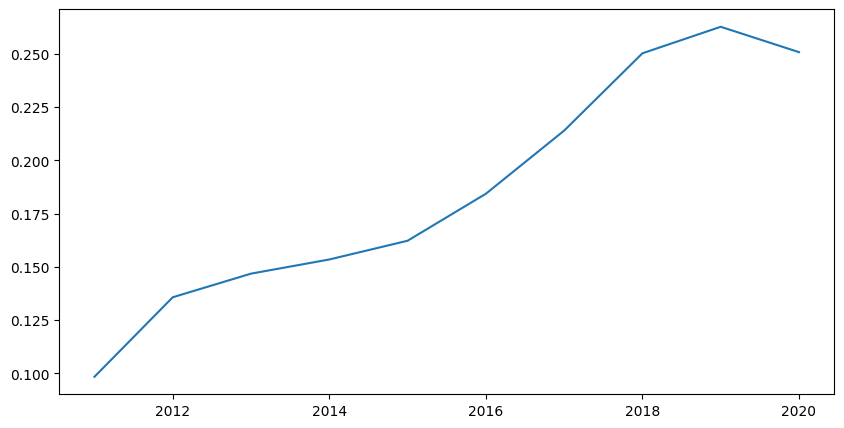

In [10]:
import numpy as np
import matplotlib.pyplot as plt

test_accuracy = np.load('test_accuracies.npy')
test_loss = np.load('test_losses.npy')

# def sigmoid_inverse(y):
#     return -np.log((1 - y) / y)
# test_loss = sigmoid_inverse(test_loss)

plt.figure(figsize=(10, 5))
plt.plot(range(2011, 2021), test_loss.max()+test_loss.min()-test_loss, label='Test Loss')
plt.show()

In [ ]:
from scipy.stats import pearsonr

tl = test_loss.max()+test_loss.min()-test_loss


array([0.09840209, 0.13571692, 0.14680561, 0.15345072, 0.16224209,
       0.18429803, 0.21393319, 0.25021701, 0.26265966, 0.25075171])

In [53]:
import numpy as np

def sigmoid_inverse(y):
    return -torch.log((1 - y) / y)

# Example usage
y = torch.tensor([0.8])  # Example value of y
x = sigmoid_inverse(y)
print(x)


tensor([1.3863])


In [52]:
import torch.nn.functional as F
F.sigmoid(torch.tensor([1.38629436]))

tensor([0.8000])

In [99]:
22+(40-22)*10

202

In [183]:
import pickle

file_path = 'preprocessed_data/train_val_graphs.pkl'

# Load the data from the pickle file
with open(file_path, 'rb') as f:
    train_val_graphs, train_val_labels = pickle.load(f)

# Now you can use the loaded data
print(f"Loaded {len(train_val_graphs)} training graphs.")
# print(np.unique(train_val_labels, return_counts=True))
train_val_labels

Loaded 60 training graphs.


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [191]:
train_val_graphs[5]

Data(num_nodes=50, edge_index=[2, 2], x=[50, 128], node_year=[50, 1], y=[50, 1])

In [130]:
file_path = 'preprocessed_data/test_graphs_2019.pkl'

# Load the data from the pickle file
with open(file_path, 'rb') as f:
    test_graphs, test_labels = pickle.load(f)

# Now you can use the loaded data
print(f"Loaded {len(test_graphs)} testing graphs.")
print(np.unique(test_labels, return_counts=True))

Loaded 364 testing graphs.
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39]), array([ 1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  1, 10, 10, 10, 10,
       10, 10, 10, 10,  1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10,  1, 10, 10, 10, 10]))


In [108]:
18+(40-18)*10, 16+(40-16)*10, 3+(40-3)*10

(238, 256, 373)

In [179]:
train_val_graphs[0].batch

# umap

In [11]:
import umap

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
node_features = sub_data.x.numpy()

embedding = reducer.fit_transform(node_features)
print(f"UMAP embedding shape: {embedding.shape}")

UMAP embedding shape: (12035, 2)


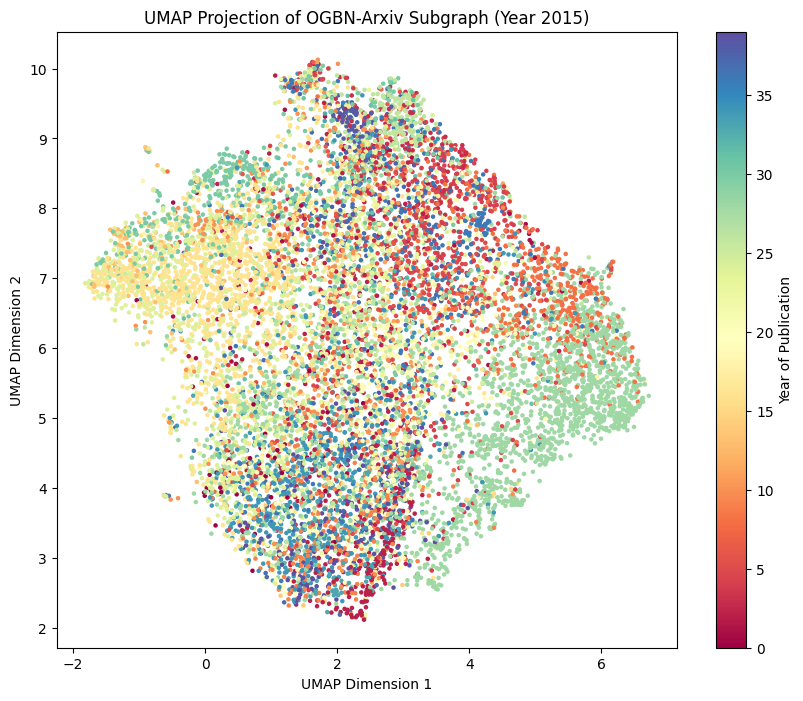

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=sub_data.y.numpy(), cmap='Spectral', s=5)
plt.colorbar(label='Year of Publication')
plt.title('UMAP Projection of OGBN-Arxiv Subgraph (Year 2015)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

UMAP embedding shape: (3564, 2)


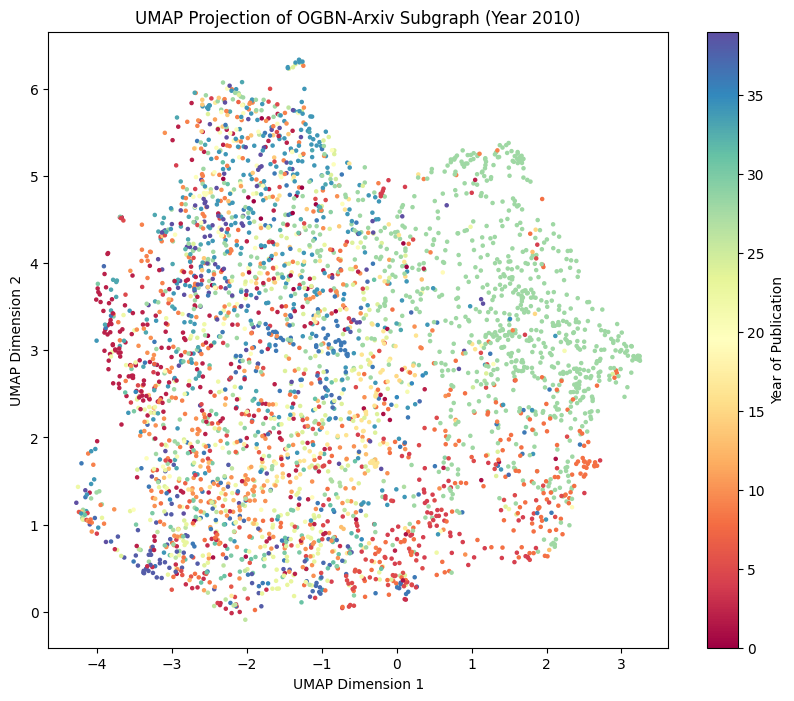

In [13]:
sub_data = get_subgraph_by_year(data, target_year=2010)

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
node_features = sub_data.x.numpy()

embedding = reducer.fit_transform(node_features)
print(f"UMAP embedding shape: {embedding.shape}")

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=sub_data.y.numpy(), cmap='Spectral', s=5)
plt.colorbar(label='Year of Publication')
plt.title('UMAP Projection of OGBN-Arxiv Subgraph (Year 2010)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [14]:
for year in range(2010,2021):
    sub_data = get_subgraph_by_year(data, target_year=year)

    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
    node_features = sub_data.x.numpy()

    embedding = reducer.fit_transform(node_features)
    print(f"UMAP embedding shape: {embedding.shape}")

    np.savetxt(f"umap_embedding_year_{year}.txt", embedding)

UMAP embedding shape: (3564, 2)
UMAP embedding shape: (4427, 2)
UMAP embedding shape: (6435, 2)
UMAP embedding shape: (8135, 2)
UMAP embedding shape: (9154, 2)
UMAP embedding shape: (12035, 2)
UMAP embedding shape: (16339, 2)
UMAP embedding shape: (21442, 2)
UMAP embedding shape: (29799, 2)
UMAP embedding shape: (39711, 2)
UMAP embedding shape: (8892, 2)


# wasserstein

Wasserstein Distance between node attributes of 2011 and 2010: 12.297584538869348
Wasserstein Distance between node attributes of 2012 and 2010: 2.3373269291633934
Wasserstein Distance between node attributes of 2013 and 2010: 3.367316364285295
Wasserstein Distance between node attributes of 2014 and 2010: 5.084998598646603
Wasserstein Distance between node attributes of 2015 and 2010: 4.022284847736083
Wasserstein Distance between node attributes of 2016 and 2010: 3.0073507238020225
Wasserstein Distance between node attributes of 2017 and 2010: 11.233135082909095
Wasserstein Distance between node attributes of 2018 and 2010: 4.402227734360946
Wasserstein Distance between node attributes of 2019 and 2010: 3.376525340679028
Wasserstein Distance between node attributes of 2020 and 2010: 5.612520480718784


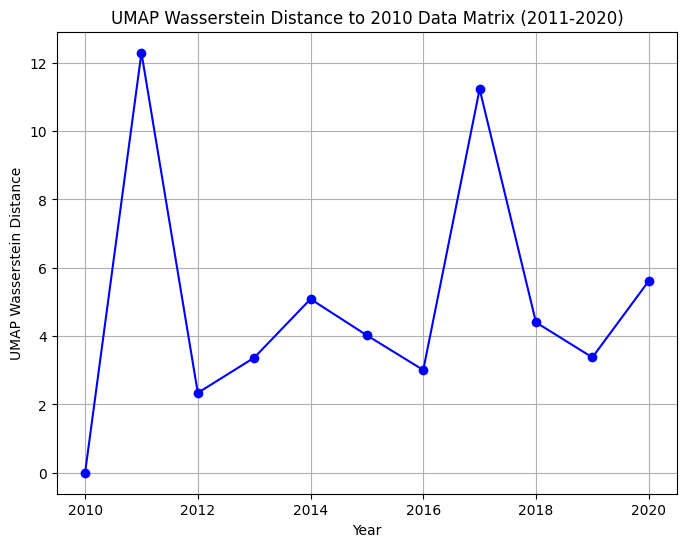

In [21]:
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

# Load the subgraphs for year 2010
sub_data_2010 = np.loadtxt('umap_embedding_year_2010.txt')

wasserstein_distances = [0]

# Loop through the years from 2011 to 2020
for year in range(2011, 2021):
    # Load the subgraph for the current year
    sub_data_X = np.loadtxt(f'umap_embedding_year_{year}.txt')
    
    # Compute the Wasserstein distance between year X and year 2010
    common_nodes = min(sub_data_2010.shape[0], sub_data_X.shape[0])  # We compare only the smallest number of nodes

    # Extract the node feature matrices for the common nodes
    feature_1 = sub_data_2010[:common_nodes]
    feature_2 = sub_data_X[:common_nodes]

    # Check if the common nodes are non-zero
    if common_nodes == 0:
        raise ValueError("No common nodes found between the two subgraphs.")

    # Compare the node attribute matrices (features)
    wasserstein_dist = 0.0
    for i in range(sub_data_2010.shape[1]):  # Iterate over each feature dimension
        # Compute the Wasserstein distance between the corresponding feature dimensions
        wasserstein_dist += wasserstein_distance(feature_1[:, i], feature_2[:, i])
    
    # Print the computed Wasserstein distance
    print(f"Wasserstein Distance between node attributes of {year} and 2010: {wasserstein_dist}")

    wasserstein_distances.append(wasserstein_dist)

# Prepare data for plotting
years = np.arange(2010, 2021)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(years, wasserstein_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('UMAP Wasserstein Distance')
plt.title('UMAP Wasserstein Distance to 2010 Data Matrix (2011-2020)')
plt.grid(True)
plt.show()

In [ ]:
np.log2(12035)/12035

np.float64(0.0011262940192240847)

In [10]:
8125 / (12035*(12035-1))

5.6100569229172656e-05

In [11]:
sub_data.edge_index

tensor([[ 8534,  8534,  1764,  ...,  9463,  8533,  6551],
        [  945,  7740,  9780,  ...,  5207, 11562,  7623]])

In [20]:
for year in sorted(year_split_dict.keys()):
    sub_data = get_subgraph_by_year(data, target_year=year)
    torch.save(sub_data, f'./dataset/ogbn_arxiv/processed/subgraph_{year}.pt')
    print(f"Year {year} subgraph:")
    print(f"- Nodes: {sub_data.num_nodes}")
    print(f"- Edges: {sub_data.edge_index.size(1)}")
    print(f"- Node features shape: {sub_data.x.shape}")
    print(f"- Node labels shape: {sub_data.y.shape}\n")

Year 1971 subgraph:
- Nodes: 1
- Edges: 0
- Node features shape: torch.Size([1, 128])
- Node labels shape: torch.Size([1, 1])

Year 1986 subgraph:
- Nodes: 1
- Edges: 0
- Node features shape: torch.Size([1, 128])
- Node labels shape: torch.Size([1, 1])

Year 1987 subgraph:
- Nodes: 1
- Edges: 0
- Node features shape: torch.Size([1, 128])
- Node labels shape: torch.Size([1, 1])

Year 1988 subgraph:
- Nodes: 1
- Edges: 0
- Node features shape: torch.Size([1, 128])
- Node labels shape: torch.Size([1, 1])

Year 1990 subgraph:
- Nodes: 3
- Edges: 0
- Node features shape: torch.Size([3, 128])
- Node labels shape: torch.Size([3, 1])

Year 1991 subgraph:
- Nodes: 3
- Edges: 0
- Node features shape: torch.Size([3, 128])
- Node labels shape: torch.Size([3, 1])

Year 1992 subgraph:
- Nodes: 1
- Edges: 0
- Node features shape: torch.Size([1, 128])
- Node labels shape: torch.Size([1, 1])

Year 1993 subgraph:
- Nodes: 8
- Edges: 0
- Node features shape: torch.Size([8, 128])
- Node labels shape: torc

In [99]:
from scipy.stats import wasserstein_distance, wasserstein_distance_nd
import torch
import ot

def sinkhorn_wasserstein2(X, Y, reg=0.1):
    N = X.shape[0]
    a = b = np.ones(N) / N  # uniform weights
    M = ot.dist(X, Y, metric='euclidean') ** 2
    transport_plan = ot.sinkhorn(a, b, M, reg)
    return np.sqrt(np.sum(transport_plan * M))

def compute_wasserstein_distance(data1, data2):
    """
    Compute the Wasserstein distance between the node attribute matrices (features)
    of two subgraphs, considering only the common nodes between them.

    Args:
        data1 (Data): PyG Data object for the first subgraph.
        data2 (Data): PyG Data object for the second subgraph.

    Returns:
        float: The Wasserstein distance between the node attribute matrices.
    """
    # Get the node indices for both subgraphs
    nodes1 = data1.x.size(0)
    nodes2 = data2.x.size(0)

    # Find the common set of node indices
    common_nodes = min(nodes1, nodes2)  # We compare only the smallest number of nodes

    # Extract the node feature matrices for the common nodes
    feature_1 = data1.x[:common_nodes].cpu().numpy()  # Slice to match common nodes
    feature_2 = data2.x[:common_nodes].cpu().numpy()  # Slice to match common nodes

    # Check if the common nodes are non-zero
    if common_nodes == 0:
        raise ValueError("No common nodes found between the two subgraphs.")

    # # Compare the node attribute matrices (features)
    # wrong implementation
    # total_wasserstein_distance = 0.0
    # for i in range(data1.x.size(1)):  # Iterate over each feature dimension
    #     # Compute the Wasserstein distance between the corresponding feature dimensions
    #     total_wasserstein_distance += wasserstein_distance(feature_1[:, i], feature_2[:, i])

    total_wasserstein_distance = sinkhorn_wasserstein2(feature_1, feature_2)

    return total_wasserstein_distance

C:\Users\wanzh\AppData\Local\Temp\ipykernel_25472\2130293252.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sub_data_2010 = torch.load('./dataset/ogbn_arxiv/processed/s

Wasserstein Distance between node attributes of 2011 and 2010: 1.2911629723166054


d:\anaconda3\envs\rebuttal\Lib\site-packages\ot\bregman\_sinkhorn.py:631: RuntimeWarning: divide by zero encountered in divide
  v = b / KtransposeU
d:\anaconda3\envs\rebuttal\Lib\site-packages\ot\bregman\_sinkhorn.py:643: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn("Warning: numerical errors at iteration %d" % ii)


Wasserstein Distance between node attributes of 2012 and 2010: 0.0006077072466723621
Wasserstein Distance between node attributes of 2013 and 2010: 0.000573517638258636
Wasserstein Distance between node attributes of 2014 and 2010: 0.0005668297526426613
Wasserstein Distance between node attributes of 2015 and 2010: 0.0005018587689846754
Wasserstein Distance between node attributes of 2016 and 2010: 0.0004846520023420453
Wasserstein Distance between node attributes of 2017 and 2010: 0.0004676536482293159
Wasserstein Distance between node attributes of 2018 and 2010: 0.0004073202726431191
Wasserstein Distance between node attributes of 2019 and 2010: 0.0004033378791064024
Wasserstein Distance between node attributes of 2020 and 2010: 0.0004284443857613951


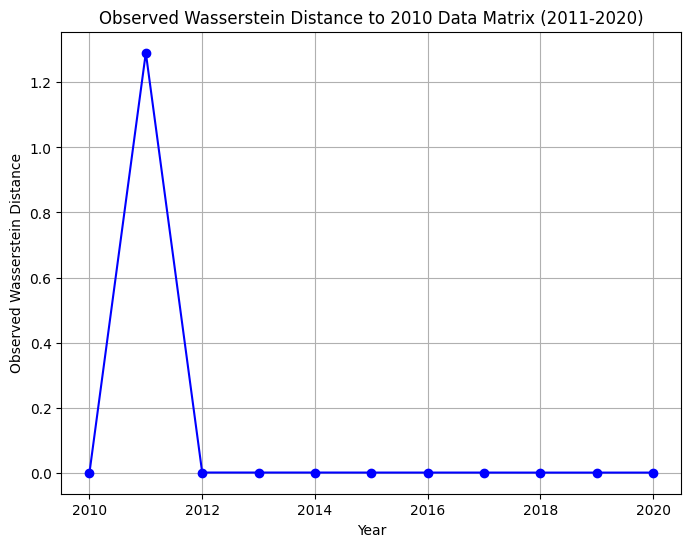

In [104]:
import matplotlib.pyplot as plt

# Load the subgraphs for year 2010
sub_data_2010 = torch.load('./dataset/ogbn_arxiv/processed/subgraph_2010.pt')

wasserstein_distances = [0]

# Loop through the years from 2011 to 2020
for year in range(2011, 2021):
    # Load the subgraph for the current year
    sub_data_X = torch.load(f'./dataset/ogbn_arxiv/processed/subgraph_{year}.pt')
    
    # Compute the Wasserstein distance between year X and year 2010
    wasserstein_dist = compute_wasserstein_distance(sub_data_X, sub_data_2010)
    
    # Print the computed Wasserstein distance
    print(f"Wasserstein Distance between node attributes of {year} and 2010: {wasserstein_dist}")

    wasserstein_distances.append(wasserstein_dist)

# Prepare data for plotting
years = np.arange(2010, 2021)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(years, wasserstein_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Observed Wasserstein Distance')
plt.title('Observed Wasserstein Distance to 2010 Data Matrix (2011-2020)')
plt.grid(True)
plt.show()

In [ ]:
# wasserstein_distances_observed = wasserstein_distances.copy()


In [106]:
# torch.save(torch.tensor(wasserstein_distances), f'output/wasserstein_distances_observed.pt')

wasserstein_distances = torch.load(f'output/wasserstein_distances_observed.pt')

import numpy as np
from scipy.stats import pearsonr, spearmanr

pearsonr(wasserstein_distances, np.arange(2010, 2021)), spearmanr(wasserstein_distances, np.arange(2010, 2021))

C:\Users\wanzh\AppData\Local\Temp\ipykernel_25472\953905257.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wasserstein_distances = torch.load(f'output/wasserstein_dista

(PearsonRResult(statistic=np.float64(-0.39991598254955746), pvalue=np.float64(0.22297462482610222)),
 SignificanceResult(statistic=np.float64(-0.4727272727272727), pvalue=np.float64(0.14199852020631992)))

In [109]:
wasserstein_distances

tensor([0.0000e+00, 1.2912e+00, 6.0771e-04, 5.7352e-04, 5.6683e-04, 5.0186e-04,
        4.8465e-04, 4.6765e-04, 4.0732e-04, 4.0334e-04, 4.2844e-04],
       dtype=torch.float64)

## wrong implementations

C:\Users\wanzh\AppData\Local\Temp\ipykernel_35420\728133342.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_2010 = torch.load("output/2010_all_mu.pt")
C:\Users\wan

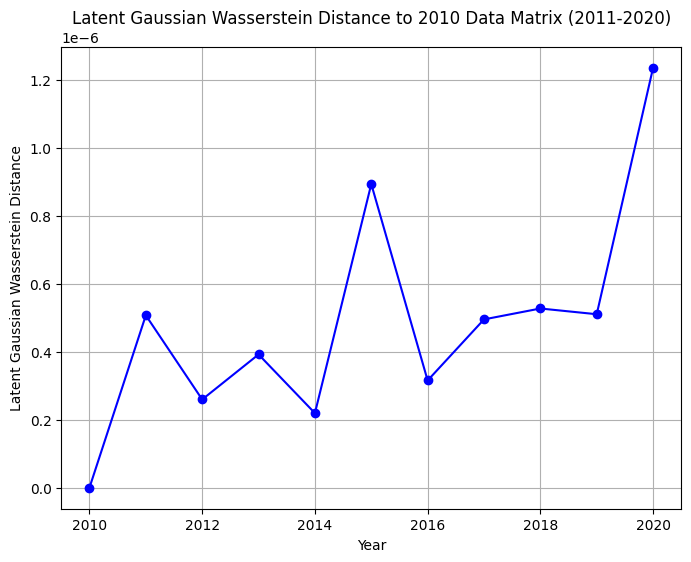

In [18]:
import torch
from scipy.stats import wasserstein_distance
import numpy as np
import matplotlib.pyplot as plt

def calculate_wasserstein_distance(data_2010, data_year):
    """Calculate the Wasserstein distance between two flattened data arrays."""
    data_2010_flat = data_2010.flatten().cpu().numpy()
    data_year_flat = data_year.flatten().cpu().numpy()
    return wasserstein_distance(data_2010_flat, data_year_flat)

# Load the 2010 data matrix (assuming it's a list of tensors)
data_2010 = torch.load("output/2010_all_mu.pt")

# If data_2010 is a list, flatten each element individually and convert them to tensors
if isinstance(data_2010, list):
    data_2010 = torch.cat([item.flatten() if isinstance(item, torch.Tensor) else torch.tensor(item).flatten() for item in data_2010])

# Initialize a list to store the Wasserstein distances
wasserstein_distances = [0]

# Loop through the years 2011 to 2020 and calculate Wasserstein distance to 2010
for year in range(2011, 2021):
    # Load the data matrix for the year
    data_year = torch.load(f"output/{year}_all_mu.pt")
    
    # If data_year is a list, flatten each element individually and convert them to tensors
    if isinstance(data_year, list):
        data_year = torch.cat([item.flatten() if isinstance(item, torch.Tensor) else torch.tensor(item).flatten() for item in data_year])
    
    # Calculate Wasserstein distance and append to the list
    distance = calculate_wasserstein_distance(data_2010, data_year)
    wasserstein_distances.append(distance)

# Prepare data for plotting
years = np.arange(2010, 2021)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(years, wasserstein_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Latent Gaussian Wasserstein Distance')
plt.title('Latent Gaussian Wasserstein Distance to 2010 Data Matrix (2011-2020)')
plt.grid(True)
plt.show()


In [19]:
wasserstein_distances_latent_Gaussian = wasserstein_distances.copy()

In [17]:
data_2010.shape

torch.Size([2138400])

In [19]:
data_2010 = torch.load(f"output/2010_Laplace_all_mu.pt")
data_2010[-1].shape

C:\Users\wanzh\AppData\Local\Temp\ipykernel_25400\1442111932.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_2010 = torch.load(f"output/2010_Laplace_all_mu.pt")


(3564, 2)

C:\Users\wanzh\AppData\Local\Temp\ipykernel_25400\146165912.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_2010 = torch.load(f"output/2010_{variational_distributi

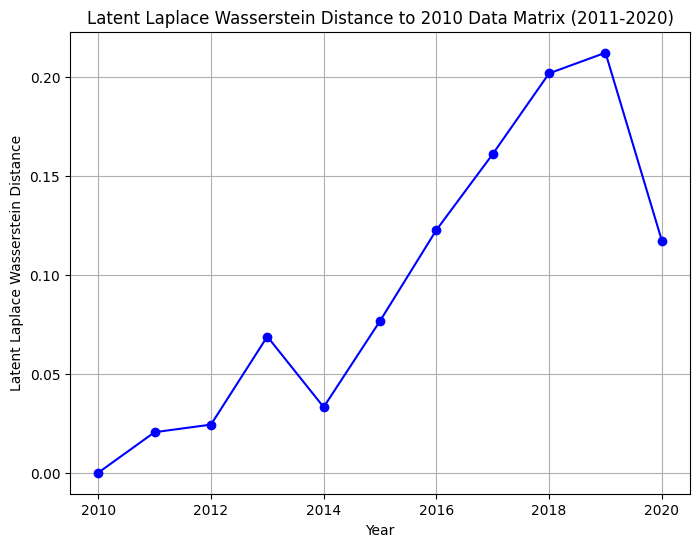

In [16]:
import torch
from scipy.stats import wasserstein_distance
import numpy as np
import matplotlib.pyplot as plt

variational_distribution = "Laplace"

def calculate_wasserstein_distance(data_2010, data_year):
    """Calculate the Wasserstein distance between two flattened data arrays."""
    data_2010_flat = data_2010.flatten().cpu().numpy()
    data_year_flat = data_year.flatten().cpu().numpy()
    return wasserstein_distance(data_2010_flat, data_year_flat)

# Load the 2010 data matrix (assuming it's a list of tensors)
data_2010 = torch.load(f"output/2010_{variational_distribution}_all_mu.pt")

# If data_2010 is a list, flatten each element individually and convert them to tensors
if isinstance(data_2010, list):
    data_2010 = torch.cat([item.flatten() if isinstance(item, torch.Tensor) else torch.tensor(item).flatten() for item in data_2010])

# Initialize a list to store the Wasserstein distances
wasserstein_distances = [0]

# Loop through the years 2011 to 2020 and calculate Wasserstein distance to 2010
for year in range(2011, 2021):
    # Load the data matrix for the year
    data_year = torch.load(f"output/{year}_{variational_distribution}_all_mu.pt")
    
    # If data_year is a list, flatten each element individually and convert them to tensors
    if isinstance(data_year, list):
        data_year = torch.cat([item.flatten() if isinstance(item, torch.Tensor) else torch.tensor(item).flatten() for item in data_year])
    
    # Calculate Wasserstein distance and append to the list
    distance = calculate_wasserstein_distance(data_2010, data_year)
    wasserstein_distances.append(distance)

# Prepare data for plotting
years = np.arange(2010, 2021)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(years, wasserstein_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel(f'Latent {variational_distribution} Wasserstein Distance')
plt.title(f'Latent {variational_distribution} Wasserstein Distance to 2010 Data Matrix (2011-2020)')
plt.grid(True)
plt.show()


In [16]:
wasserstein_distances_latent_Laplace = wasserstein_distances.copy()

C:\Users\wanzh\AppData\Local\Temp\ipykernel_35420\1263106589.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_2010 = torch.load(f"output/2010_{variational_distribut

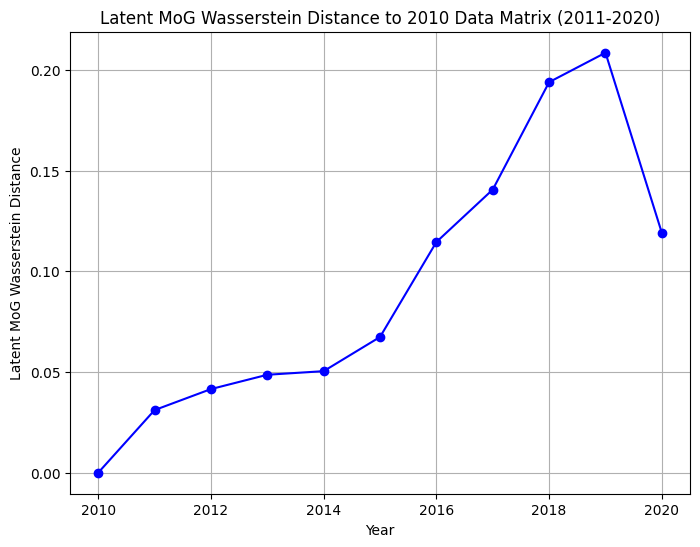

In [13]:
import torch
from scipy.stats import wasserstein_distance
import numpy as np
import matplotlib.pyplot as plt

variational_distribution = "MoG"

def calculate_wasserstein_distance(data_2010, data_year):
    """Calculate the Wasserstein distance between two flattened data arrays."""
    data_2010_flat = data_2010.flatten().cpu().numpy()
    data_year_flat = data_year.flatten().cpu().numpy()
    return wasserstein_distance(data_2010_flat, data_year_flat)

# Load the 2010 data matrix (assuming it's a list of tensors)
data_2010 = torch.load(f"output/2010_{variational_distribution}_all_mu.pt")

# If data_2010 is a list, flatten each element individually and convert them to tensors
if isinstance(data_2010, list):
    data_2010 = torch.cat([item.flatten() if isinstance(item, torch.Tensor) else torch.tensor(item).flatten() for item in data_2010])

# Initialize a list to store the Wasserstein distances
wasserstein_distances = [0]

# Loop through the years 2011 to 2020 and calculate Wasserstein distance to 2010
for year in range(2011, 2021):
    # Load the data matrix for the year
    data_year = torch.load(f"output/{year}_{variational_distribution}_all_mu.pt")
    
    # If data_year is a list, flatten each element individually and convert them to tensors
    if isinstance(data_year, list):
        data_year = torch.cat([item.flatten() if isinstance(item, torch.Tensor) else torch.tensor(item).flatten() for item in data_year])
    
    # Calculate Wasserstein distance and append to the list
    distance = calculate_wasserstein_distance(data_2010, data_year)
    wasserstein_distances.append(distance)

# Prepare data for plotting
years = np.arange(2010, 2021)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(years, wasserstein_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel(f'Latent {variational_distribution} Wasserstein Distance')
plt.title(f'Latent {variational_distribution} Wasserstein Distance to 2010 Data Matrix (2011-2020)')
plt.grid(True)
plt.show()


In [14]:
wasserstein_distances_latent_MoG = wasserstein_distances.copy()

C:\Users\wanzh\AppData\Local\Temp\ipykernel_35420\3721089535.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_2010 = torch.load(f"output/2010_{variational_distribut

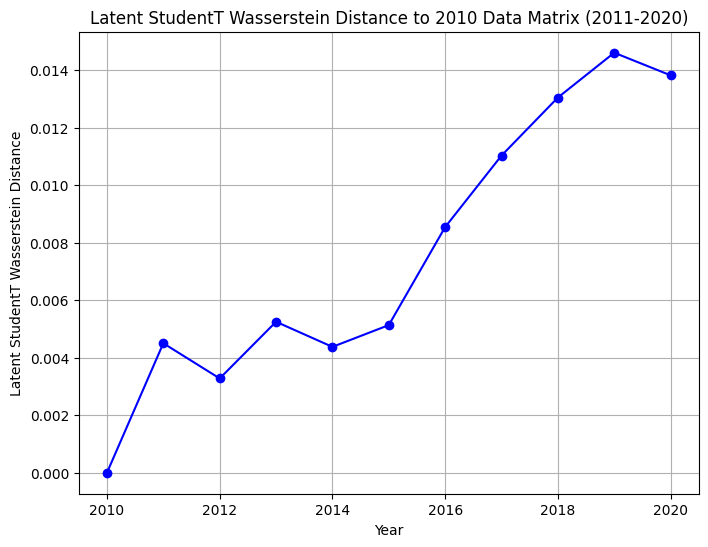

In [10]:
import torch
from scipy.stats import wasserstein_distance
import numpy as np
import matplotlib.pyplot as plt

variational_distribution = "StudentT"

def calculate_wasserstein_distance(data_2010, data_year):
    """Calculate the Wasserstein distance between two flattened data arrays."""
    data_2010_flat = data_2010.flatten().cpu().numpy()
    data_year_flat = data_year.flatten().cpu().numpy()
    return wasserstein_distance(data_2010_flat, data_year_flat)

# Load the 2010 data matrix (assuming it's a list of tensors)
data_2010 = torch.load(f"output/2010_{variational_distribution}_all_mu.pt")

# If data_2010 is a list, flatten each element individually and convert them to tensors
if isinstance(data_2010, list):
    data_2010 = torch.cat([item.flatten() if isinstance(item, torch.Tensor) else torch.tensor(item).flatten() for item in data_2010])

# Initialize a list to store the Wasserstein distances
wasserstein_distances = [0]

# Loop through the years 2011 to 2020 and calculate Wasserstein distance to 2010
for year in range(2011, 2021):
    # Load the data matrix for the year
    data_year = torch.load(f"output/{year}_{variational_distribution}_all_mu.pt")
    
    # If data_year is a list, flatten each element individually and convert them to tensors
    if isinstance(data_year, list):
        data_year = torch.cat([item.flatten() if isinstance(item, torch.Tensor) else torch.tensor(item).flatten() for item in data_year])
    
    # Calculate Wasserstein distance and append to the list
    distance = calculate_wasserstein_distance(data_2010, data_year)
    wasserstein_distances.append(distance)

# Prepare data for plotting
years = np.arange(2010, 2021)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(years, wasserstein_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel(f'Latent {variational_distribution} Wasserstein Distance')
plt.title(f'Latent {variational_distribution} Wasserstein Distance to 2010 Data Matrix (2011-2020)')
plt.grid(True)
plt.show()


C:\Users\wanzh\AppData\Local\Temp\ipykernel_25400\3721089535.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_2010 = torch.load(f"output/2010_{variational_distribut

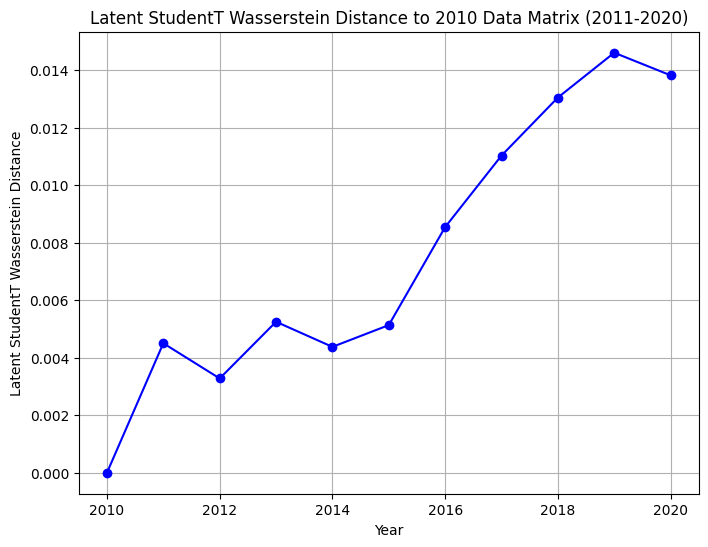

In [14]:
import torch
from scipy.stats import wasserstein_distance
import numpy as np
import matplotlib.pyplot as plt

variational_distribution = "StudentT"

def calculate_wasserstein_distance(data_2010, data_year):
    """Calculate the Wasserstein distance between two flattened data arrays."""
    data_2010_flat = data_2010.flatten().cpu().numpy()
    data_year_flat = data_year.flatten().cpu().numpy()
    return wasserstein_distance(data_2010_flat, data_year_flat)

# Load the 2010 data matrix (assuming it's a list of tensors)
data_2010 = torch.load(f"output/2010_{variational_distribution}_all_mu.pt")

# If data_2010 is a list, flatten each element individually and convert them to tensors
if isinstance(data_2010, list):
    data_2010 = torch.cat([item.flatten() if isinstance(item, torch.Tensor) else torch.tensor(item).flatten() for item in data_2010])

# Initialize a list to store the Wasserstein distances
wasserstein_distances = [0]

# Loop through the years 2011 to 2020 and calculate Wasserstein distance to 2010
for year in range(2011, 2021):
    # Load the data matrix for the year
    data_year = torch.load(f"output/{year}_{variational_distribution}_all_mu.pt")
    
    # If data_year is a list, flatten each element individually and convert them to tensors
    if isinstance(data_year, list):
        data_year = torch.cat([item.flatten() if isinstance(item, torch.Tensor) else torch.tensor(item).flatten() for item in data_year])
    
    # Calculate Wasserstein distance and append to the list
    distance = calculate_wasserstein_distance(data_2010, data_year)
    wasserstein_distances.append(distance)

# Prepare data for plotting
years = np.arange(2010, 2021)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(years, wasserstein_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel(f'Latent {variational_distribution} Wasserstein Distance')
plt.title(f'Latent {variational_distribution} Wasserstein Distance to 2010 Data Matrix (2011-2020)')
plt.grid(True)
plt.show()


In [12]:
wasserstein_distances_latent_studentT = wasserstein_distances.copy()

C:\Users\wanzh\AppData\Local\Temp\ipykernel_35420\583973923.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_2010 = torch.load(f"output/2010_{variational_distributi

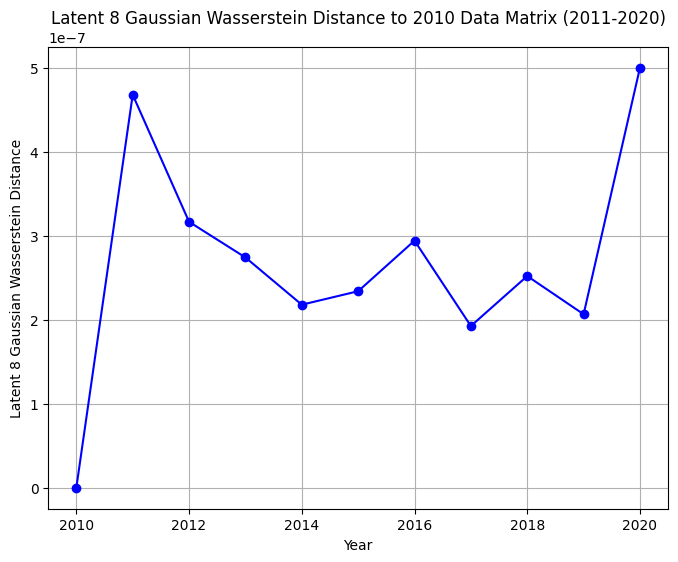

In [37]:
import torch
from scipy.stats import wasserstein_distance
import numpy as np
import matplotlib.pyplot as plt

variational_distribution = "Gaussian"
latent_dim = 8

def calculate_wasserstein_distance(data_2010, data_year):
    """Calculate the Wasserstein distance between two flattened data arrays."""
    data_2010_flat = data_2010.flatten().cpu().numpy()
    data_year_flat = data_year.flatten().cpu().numpy()
    return wasserstein_distance(data_2010_flat, data_year_flat)

# Load the 2010 data matrix (assuming it's a list of tensors)
data_2010 = torch.load(f"output/2010_{variational_distribution}_{latent_dim}_all_mu.pt")

# If data_2010 is a list, flatten each element individually and convert them to tensors
if isinstance(data_2010, list):
    data_2010 = torch.cat([item.flatten() if isinstance(item, torch.Tensor) else torch.tensor(item).flatten() for item in data_2010])

# Initialize a list to store the Wasserstein distances
wasserstein_distances = [0]

# Loop through the years 2011 to 2020 and calculate Wasserstein distance to 2010
for year in range(2011, 2021):
    # Load the data matrix for the year
    data_year = torch.load(f"output/{year}_{variational_distribution}_{latent_dim}_all_mu.pt")
    
    # If data_year is a list, flatten each element individually and convert them to tensors
    if isinstance(data_year, list):
        data_year = torch.cat([item.flatten() if isinstance(item, torch.Tensor) else torch.tensor(item).flatten() for item in data_year])
    
    # Calculate Wasserstein distance and append to the list
    distance = calculate_wasserstein_distance(data_2010, data_year)
    wasserstein_distances.append(distance)

# Prepare data for plotting
years = np.arange(2010, 2021)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(years, wasserstein_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel(f'Latent {latent_dim} {variational_distribution} Wasserstein Distance')
plt.title(f'Latent {latent_dim} {variational_distribution} Wasserstein Distance to 2010 Data Matrix (2011-2020)')
plt.grid(True)
plt.show()


In [38]:
wasserstein_distances_latent_Gaussian_dim8 = wasserstein_distances.copy()

## corrected

C:\Users\wanzh\AppData\Local\Temp\ipykernel_25400\2113723577.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_2010 = torch.load(f"output/2010_all_mu.pt")
  0%|     

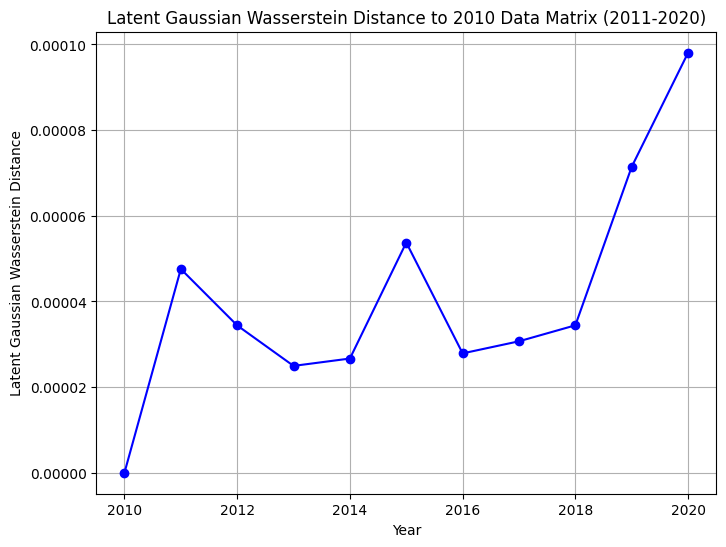

In [54]:
import torch
from scipy.stats import wasserstein_distance
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

variational_distribution = "Gaussian"       # Gaussian

# Load the 2010 data matrix (assuming it's a list of tensors)
data_2010 = torch.load(f"output/2010_all_mu.pt")

# Initialize a list to store the Wasserstein distances
wasserstein_distances = [0]

# Loop through the years 2011 to 2020 and calculate Wasserstein distance to 2010
for year in tqdm(range(2011, 2021)):
    # Load the data matrix for the year
    data_year = torch.load(f"output/{year}_all_mu.pt")
    
    num_nodes = min(data_year[-1].shape[0], data_2010[-1].shape[0])  # Compare only the smallest number of nodes
    # Extract the node feature matrices for the common nodes
    idx = np.random.choice(data_year[-1].shape[0], num_nodes, replace=False)
    feature_1 = data_year[-1][idx]  # Random
    feature_2 = data_2010[-1]  # Randomly selected features

    # Calculate Wasserstein distance and append to the list
    distance = sinkhorn_wasserstein2(feature_1, feature_2)
    wasserstein_distances.append(distance)

# Prepare data for plotting
years = np.arange(2010, 2021)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(years, wasserstein_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel(f'Latent Gaussian Wasserstein Distance')
plt.title(f'Latent Gaussian Wasserstein Distance to 2010 Data Matrix (2011-2020)')
plt.grid(True)
plt.show()


In [110]:
# torch.save(torch.tensor(wasserstein_distances), f'output/wasserstein_distances_latent_{variational_distribution}.pt')

wasserstein_distances = torch.load(f'output/wasserstein_distances_latent_Gaussian.pt')

import numpy as np
from scipy.stats import pearsonr, spearmanr

pearsonr(wasserstein_distances, np.arange(2010, 2021)), spearmanr(wasserstein_distances, np.arange(2010, 2021))

C:\Users\wanzh\AppData\Local\Temp\ipykernel_25472\203232611.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wasserstein_distances = torch.load(f'output/wasserstein_dista

(PearsonRResult(statistic=np.float64(0.6871787189263783), pvalue=np.float64(0.019476993919090295)),
 SignificanceResult(statistic=np.float64(0.6181818181818182), pvalue=np.float64(0.042645569805326695)))

In [111]:
wasserstein_distances

tensor([0.0000e+00, 4.7563e-05, 3.4389e-05, 2.4941e-05, 2.6661e-05, 5.3741e-05,
        2.7866e-05, 3.0687e-05, 3.4418e-05, 7.1439e-05, 9.8060e-05],
       dtype=torch.float64)

C:\Users\wanzh\AppData\Local\Temp\ipykernel_25400\1970892964.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_2010 = torch.load(f"output/2010_{variational_distribut

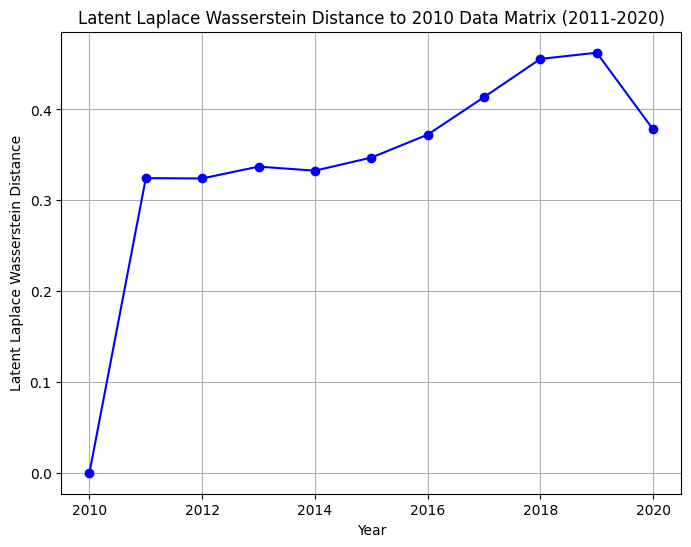

In [52]:
import torch
from scipy.stats import wasserstein_distance
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

variational_distribution = "Laplace"

# Load the 2010 data matrix (assuming it's a list of tensors)
data_2010 = torch.load(f"output/2010_{variational_distribution}_all_mu.pt")

# Initialize a list to store the Wasserstein distances
wasserstein_distances = [0]

# Loop through the years 2011 to 2020 and calculate Wasserstein distance to 2010
for year in tqdm(range(2011, 2021)):
    # Load the data matrix for the year
    data_year = torch.load(f"output/{year}_{variational_distribution}_all_mu.pt")
    
    num_nodes = min(data_year[-1].shape[0], data_2010[-1].shape[0])  # Compare only the smallest number of nodes
    # Extract the node feature matrices for the common nodes
    idx = np.random.choice(data_year[-1].shape[0], num_nodes, replace=False)
    feature_1 = data_year[-1][idx]  # Random
    feature_2 = data_2010[-1]  # Randomly selected features

    # Calculate Wasserstein distance and append to the list
    distance = sinkhorn_wasserstein2(feature_1, feature_2)
    wasserstein_distances.append(distance)

# Prepare data for plotting
years = np.arange(2010, 2021)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(years, wasserstein_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel(f'Latent {variational_distribution} Wasserstein Distance')
plt.title(f'Latent {variational_distribution} Wasserstein Distance to 2010 Data Matrix (2011-2020)')
plt.grid(True)
plt.show()


In [112]:
wasserstein_distances = torch.load(f'output/wasserstein_distances_latent_Laplace.pt')

import numpy as np
from scipy.stats import pearsonr, spearmanr

pearsonr(wasserstein_distances, np.arange(2010, 2021)), spearmanr(wasserstein_distances, np.arange(2010, 2021))

C:\Users\wanzh\AppData\Local\Temp\ipykernel_25472\1114792730.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wasserstein_distances = torch.load(f'output/wasserstein_dist

(PearsonRResult(statistic=np.float64(0.7398260931266998), pvalue=np.float64(0.00924645694930232)),
 SignificanceResult(statistic=np.float64(0.9272727272727275), pvalue=np.float64(3.973774256558543e-05)))

In [113]:
wasserstein_distances

tensor([0.0000, 0.3243, 0.3240, 0.3370, 0.3325, 0.3470, 0.3722, 0.4135, 0.4556,
        0.4624, 0.3779], dtype=torch.float64)

C:\Users\wanzh\AppData\Local\Temp\ipykernel_25400\3006286283.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_2010 = torch.load(f"output/2010_{variational_distribut

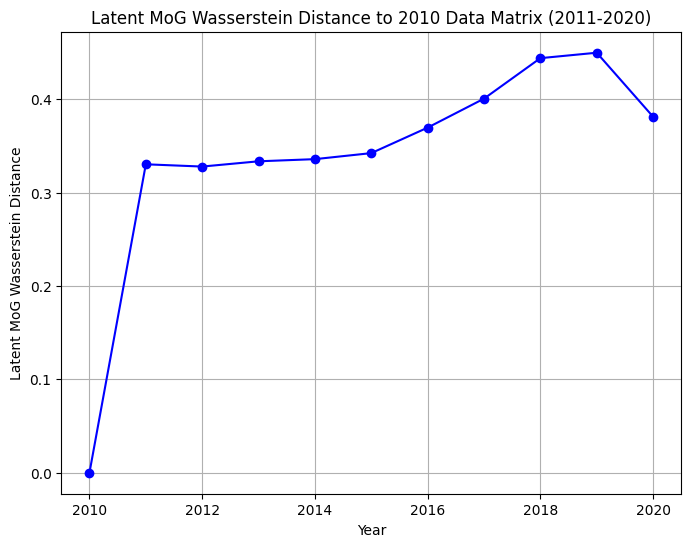

In [45]:
import torch
from scipy.stats import wasserstein_distance
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

variational_distribution = "MoG"

# Load the 2010 data matrix (assuming it's a list of tensors)
data_2010 = torch.load(f"output/2010_{variational_distribution}_all_mu.pt")

# Initialize a list to store the Wasserstein distances
wasserstein_distances = [0]

# Loop through the years 2011 to 2020 and calculate Wasserstein distance to 2010
for year in tqdm(range(2011, 2021)):
    # Load the data matrix for the year
    data_year = torch.load(f"output/{year}_{variational_distribution}_all_mu.pt")
    
    num_nodes = min(data_year[-1].shape[0], data_2010[-1].shape[0])  # Compare only the smallest number of nodes
    # Extract the node feature matrices for the common nodes
    idx = np.random.choice(data_year[-1].shape[0], num_nodes, replace=False)
    feature_1 = data_year[-1][idx]  # Random
    feature_2 = data_2010[-1]  # Randomly selected features

    # Calculate Wasserstein distance and append to the list
    distance = sinkhorn_wasserstein2(feature_1, feature_2)
    wasserstein_distances.append(distance)

# Prepare data for plotting
years = np.arange(2010, 2021)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(years, wasserstein_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel(f'Latent {variational_distribution} Wasserstein Distance')
plt.title(f'Latent {variational_distribution} Wasserstein Distance to 2010 Data Matrix (2011-2020)')
plt.grid(True)
plt.show()


In [114]:
wasserstein_distances = torch.load(f'output/wasserstein_distances_latent_MoG.pt')

import numpy as np
from scipy.stats import pearsonr, spearmanr

pearsonr(wasserstein_distances, np.arange(2010, 2021)), spearmanr(wasserstein_distances, np.arange(2010, 2021))

C:\Users\wanzh\AppData\Local\Temp\ipykernel_25472\1824873406.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wasserstein_distances = torch.load(f'output/wasserstein_dist

(PearsonRResult(statistic=np.float64(0.7263107641009646), pvalue=np.float64(0.011366496016724712)),
 SignificanceResult(statistic=np.float64(0.9363636363636365), pvalue=np.float64(2.208207644917754e-05)))

In [115]:
wasserstein_distances

tensor([0.0000, 0.3303, 0.3279, 0.3335, 0.3358, 0.3423, 0.3696, 0.4006, 0.4440,
        0.4498, 0.3812], dtype=torch.float64)

C:\Users\wanzh\AppData\Local\Temp\ipykernel_25400\2516533904.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_2010 = torch.load(f"output/2010_{variational_distribut

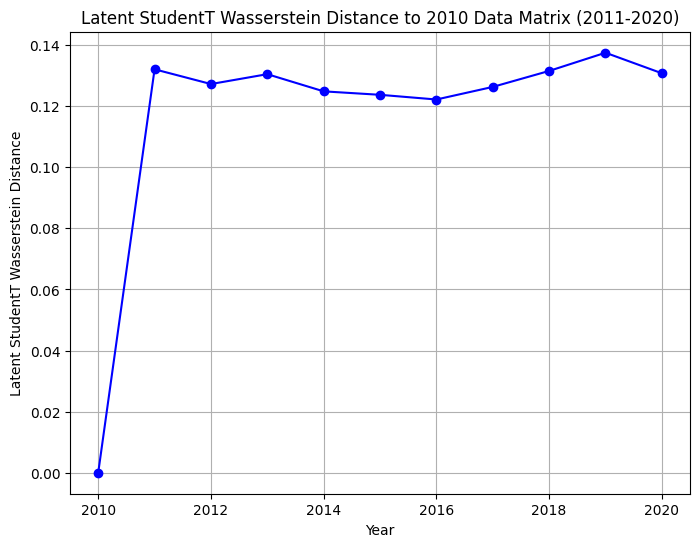

In [56]:
import torch
from scipy.stats import wasserstein_distance
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

variational_distribution = "StudentT"

# Load the 2010 data matrix (assuming it's a list of tensors)
data_2010 = torch.load(f"output/2010_{variational_distribution}_all_mu.pt")

# Initialize a list to store the Wasserstein distances
wasserstein_distances = [0]

# Loop through the years 2011 to 2020 and calculate Wasserstein distance to 2010
for year in tqdm(range(2011, 2021)):
    # Load the data matrix for the year
    data_year = torch.load(f"output/{year}_{variational_distribution}_all_mu.pt")
    
    num_nodes = min(data_year[-1].shape[0], data_2010[-1].shape[0])  # Compare only the smallest number of nodes
    # Extract the node feature matrices for the common nodes
    idx = np.random.choice(data_year[-1].shape[0], num_nodes, replace=False)
    feature_1 = data_year[-1][idx]  # Random
    feature_2 = data_2010[-1]  # Randomly selected features

    # Calculate Wasserstein distance and append to the list
    distance = sinkhorn_wasserstein2(feature_1, feature_2)
    wasserstein_distances.append(distance)

# Prepare data for plotting
years = np.arange(2010, 2021)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(years, wasserstein_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel(f'Latent {variational_distribution} Wasserstein Distance')
plt.title(f'Latent {variational_distribution} Wasserstein Distance to 2010 Data Matrix (2011-2020)')
plt.grid(True)
plt.show()


In [103]:
wasserstein_distances = torch.load(f'output/wasserstein_distances_latent_StudentT.pt')

import numpy as np
from scipy.stats import pearsonr, spearmanr

pearsonr(wasserstein_distances, np.arange(2010, 2021)), spearmanr(wasserstein_distances, np.arange(2010, 2021))

C:\Users\wanzh\AppData\Local\Temp\ipykernel_25472\3919612127.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wasserstein_distances = torch.load(f'output/wasserstein_dist

(PearsonRResult(statistic=np.float64(0.5231271611981493), pvalue=np.float64(0.09868439525313571)),
 SignificanceResult(statistic=np.float64(0.38181818181818183), pvalue=np.float64(0.24655957577897006)))

## stat

In [39]:
Ws = [
    np.array(wasserstein_distances_observed),
    np.array(wasserstein_distances_latent_Gaussian),
    np.array(wasserstein_distances_latent_Laplace),
    np.array(wasserstein_distances_latent_MoG),
    np.array(wasserstein_distances_latent_studentT),
    np.array(wasserstein_distances_latent_Gaussian_dim8)
]

import numpy as np
from scipy.stats import pearsonr

vectors = np.column_stack(Ws)

# Pearson correlation using numpy
correlation_matrix = np.zeros((len(Ws), len(Ws)))
for i in range(len(Ws)):
    for j in range(len(Ws)):
        correlation_matrix[i, j] = pearsonr(vectors[:, i], vectors[:, j])[0]

# Display the correlation matrix
print("Pearson Correlation Matrix:")
print(correlation_matrix)


Pearson Correlation Matrix:
[[1.         0.58836977 0.93720639 0.94927139 0.98298109 0.2490792 ]
 [0.58836977 1.         0.36860355 0.36659969 0.58668733 0.63793492]
 [0.93720639 0.36860355 1.         0.98671363 0.92639813 0.02676607]
 [0.94927139 0.36659969 0.98671363 1.         0.9407252  0.07710682]
 [0.98298109 0.58668733 0.92639813 0.9407252  1.         0.32351646]
 [0.2490792  0.63793492 0.02676607 0.07710682 0.32351646 1.        ]]


In [40]:
np.save('Ws.npy', Ws)

In [53]:
sub_data.edge_index.shape

torch.Size([2, 8125])

In [60]:
import torch
from ogb.nodeproppred import NodePropPredDataset

for year in range(2010, 2021):
    sub_data = get_subgraph_by_year(data, target_year=year)

    # Now extract the edge_index and node features from the sub_data
    edge_index = sub_data.edge_index.numpy()  # Edge indices (PyTorch tensor)
    node_features = sub_data.x.numpy()  # Node features (PyTorch tensor)

    # Save the adjacency matrix and node features for transfer to R
    np.savetxt(f'dataset/ogbn_arxiv/processed/{year}_edge_index.csv', edge_index, delimiter=',')
    np.savetxt(f'dataset/ogbn_arxiv/processed/{year}_node_features.csv', node_features, delimiter=',')

# 1. graphon estimation

- fails, because grpahon only applies to dense graphs

In [6]:
import numpy as np
from torch_geometric.utils import subgraph, to_scipy_sparse_matrix
from scipy.sparse.linalg import svds
from ogb.nodeproppred import PygNodePropPredDataset
import matplotlib.pyplot as plt

def estimate_graphon_usvt(data, tau=None, rank=50, return_dense=False, c=2.0):
    # Convert to sparse adjacency matrix
    A = to_scipy_sparse_matrix(data.edge_index, num_nodes=data.num_nodes).astype(np.float64)
    A = 0.5 * (A + A.T)  # Make symmetric

    n = A.shape[0]
    if tau is None:
        tau = c * np.sqrt(n)  # universal threshold

    # Compute top singular values/vectors
    u, s, vt = svds(A, k=rank)
    s, u, vt = s[::-1], u[:, ::-1], vt[::-1, :]  # descending order

    # Apply USVT threshold
    mask = s >= tau
    if mask.sum() == 0:
        raise RuntimeError("No singular values passed the threshold.")
    s_thresh = s[mask]
    u_thresh = u[:, mask]
    vt_thresh = vt[mask, :]

    # Return sparse-friendly reconstruction if needed
    if return_dense:
        W_hat = u_thresh @ np.diag(s_thresh) @ vt_thresh
        W_hat = np.clip(W_hat, 0, 1)
        return W_hat
    else:
        return (u_thresh, s_thresh, vt_thresh)  # Low-rank form

In [ ]:
# # === Load and estimate graphon for 2015 ===
# dataset = PygNodePropPredDataset(name='ogbn-arxiv')
# data = dataset[0]
# sub_data = get_subgraph_by_year(data, 2015)

# U, S, Vt = estimate_graphon_usvt(sub_data, rank=200, return_dense=False, c=2.01)
# W_hat = U @ np.diag(S) @ Vt

# plt.imshow(W_hat[:100, :100], cmap='viridis')
# plt.title("USVT Graphon Estimate (top-left 100x100 block)")
# plt.colorbar()
# plt.show()

d:\anaconda3\envs\rebuttal\Lib\site-packages\ogb\nodeproppred\dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.proce

RuntimeError: No singular values passed the threshold.

In [10]:
def cutoff(A, vmin = 0, vmax = 1):
    B = A.clone()
    B[B > vmax] = vmax
    B[B < vmin] = vmin
    return B

def USVT(A, gamma=.5, rho=1, cut=True, vmin=0, vmax=1, verbose=False):
    n = A.shape[0]
    s, v = torch.linalg.eigh(A)
    if verbose:
        print((s < gamma*np.sqrt(rho*n)).sum()/n, ' percent of eig are suppressed')
    s[s < gamma*np.sqrt(rho*n)] = 0
    Ahat = (v * s) @ v.t() / rho
    if cut:
        return cutoff(Ahat, vmin, vmax)
    return Ahat

In [73]:
A = to_scipy_sparse_matrix(sub_data_2015.edge_index, num_nodes=sub_data_2015.num_nodes).astype(np.float64)
A = 0.5 * (A + A.T)  # Make symmetric

n = A.shape[0]
# if tau is None:
#     tau = c * np.sqrt(n)  # universal threshold

# Compute top singular values/vectors
u, s, vt = svds(A, k=50)
s, u, vt = s[::-1], u[:, ::-1], vt[::-1, :]
u.shape, s.shape, vt.shape

((12035, 50), (50,), (50, 12035))

In [84]:
A.shape

(12035, 12035)

In [74]:
s

array([8.41264892, 7.00463681, 6.70898712, 5.99880864, 5.60696223,
       5.37582492, 4.94800858, 4.83193198, 4.56123475, 4.32662767,
       4.22685614, 3.98469932, 3.95362555, 3.93580465, 3.87313753,
       3.85830258, 3.78921485, 3.72703447, 3.6270938 , 3.62499389,
       3.55756999, 3.51550835, 3.47883201, 3.4709502 , 3.44067533,
       3.43816933, 3.43102536, 3.39726847, 3.37283454, 3.36896706,
       3.32640029, 3.28971974, 3.23509995, 3.22733524, 3.17561071,
       3.15097279, 3.11054292, 3.10849189, 3.09607035, 3.07837168,
       3.07064859, 3.04969429, 3.01949685, 2.98166041, 2.9536694 ,
       2.93464639, 2.93160848, 2.93023591, 2.89916897, 2.89178521])

In [71]:
tau = 2.01 * np.sqrt(n)  # universal threshold

# Apply USVT threshold
mask = s >= tau
if mask.sum() == 0:
    raise RuntimeError("No singular values passed the threshold.")
s_thresh = s[mask]
u_thresh = u[:, mask]
vt_thresh = vt[mask, :]

u_thresh.shape, s_thresh.shape, vt_thresh.shape

RuntimeError: No singular values passed the threshold.

In [69]:
s_thresh

array([8.41264892, 7.00463681, 6.70898712, 5.99880864, 5.60696223,
       5.37582492, 4.94800858, 4.83193198, 4.56123475, 4.32662767,
       4.22685614, 3.98469932, 3.95362555, 3.93580465, 3.87313753,
       3.85830258, 3.78921485, 3.72703447, 3.6270938 , 3.62499389,
       3.55756999, 3.51550835, 3.47883201, 3.4709502 , 3.44067533,
       3.43816933, 3.43102536, 3.39726847, 3.37283454, 3.36896706,
       3.32640029, 3.28971974, 3.23509995, 3.22733524, 3.17561071,
       3.15097279, 3.11054292, 3.10849189, 3.09607035, 3.07837168,
       3.07064859, 3.04969429, 3.01949685, 2.98166041, 2.9536694 ,
       2.93464639, 2.93160848, 2.93023591, 2.89916897, 2.89178521])

In [63]:
np.count_nonzero(u[0, :])

50

# 2. USVT

In [1]:
# dataset = PygNodePropPredDataset(name='ogbn-arxiv')
# data = dataset[0]
# sub_data = get_subgraph_by_year(data, 2015)

# A = to_scipy_sparse_matrix(sub_data.edge_index, num_nodes=sub_data.num_nodes).astype(np.float64)
# best_loss, best_W = np.inf, None
# for gamma in np.linspace(.1, .7, 25):
#     W_hat = USVT(A, gamma=gamma, verbose=False)
#     l = np.linalg.norm(W_hat.cpu().numpy() - A, ord='fro')/n
#     if l<best_loss:
#         best_loss = l
#         best_W = W_hat

import numpy as np
import torch
from torch_geometric.utils import to_scipy_sparse_matrix
from ogb.nodeproppred import PygNodePropPredDataset

def cutoff(A, vmin=0.0, vmax=1.0):
    # A is a torch.Tensor
    B = A.clone()
    B[B > vmax] = vmax
    B[B < vmin] = vmin
    return B

def USVT(A_dense_t, gamma=0.5, rho=None, cut=True, vmin=0.0, vmax=1.0, verbose=False):
    """
    A_dense_t: torch.Tensor, shape (n, n), symmetric
    rho: edge density. If None, estimate as A.mean().item()
    """
    n = A_dense_t.shape[0]
    if rho is None:
        rho = A_dense_t.mean().item() if n > 0 else 1.0
        rho = max(rho, 1e-12)  # avoid division by zero

    # eigendecomposition (A is symmetric)
    # returns eigenvalues in ascending order and eigenvectors in columns
    s, v = torch.linalg.eigh(A_dense_t)

    thr = gamma * torch.sqrt(torch.tensor(rho * n, dtype=s.dtype, device=s.device))
    suppressed = (s < thr).sum().item()
    if verbose:
        print(f"{suppressed / n:.3f} of eigenvalues suppressed")

    s = torch.where(s < thr, torch.zeros_like(s), s)

    # Reconstruct: V diag(s) V^T, then de-bias by rho
    Ahat = (v * s) @ v.T
    Ahat = Ahat / rho

    if cut:
        Ahat = cutoff(Ahat, vmin, vmax)
    return Ahat

In [2]:
from torch_geometric.utils import subgraph

def get_subgraph_by_year(data, target_year):
    years = data.node_year.squeeze()
    node_mask = (years == target_year)
    selected_nodes = node_mask.nonzero(as_tuple=True)[0]

    if selected_nodes.numel() == 0:
        raise ValueError(f"No nodes found for year {target_year}.")

    # Relabel nodes in the edge_index to range 0..len(selected_nodes)-1
    sub_edge_index, _ = subgraph(selected_nodes, data.edge_index, relabel_nodes=True)

    # Build subgraph data object
    sub_data = data.clone()
    sub_data.edge_index = sub_edge_index
    sub_data.x = data.x[selected_nodes]
    sub_data.y = data.y[selected_nodes]
    sub_data.node_year = data.node_year[selected_nodes]
    sub_data.num_nodes = selected_nodes.size(0)  # <-- Fix: correct graph size

    return sub_data


In [10]:
import numpy as np
np.linspace(0.01, 3, 40)

array([0.01      , 0.08666667, 0.16333333, 0.24      , 0.31666667,
       0.39333333, 0.47      , 0.54666667, 0.62333333, 0.7       ,
       0.77666667, 0.85333333, 0.93      , 1.00666667, 1.08333333,
       1.16      , 1.23666667, 1.31333333, 1.39      , 1.46666667,
       1.54333333, 1.62      , 1.69666667, 1.77333333, 1.85      ,
       1.92666667, 2.00333333, 2.08      , 2.15666667, 2.23333333,
       2.31      , 2.38666667, 2.46333333, 2.54      , 2.61666667,
       2.69333333, 2.77      , 2.84666667, 2.92333333, 3.        ])

In [12]:
np.linspace(0.01, 0.2, 20)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ])

In [3]:
from tqdm import tqdm

# --- Data prep
dataset = PygNodePropPredDataset(name='ogbn-arxiv')
data = dataset[0]

# your helper; make sure this returns a subgraph as intended
sub_data = get_subgraph_by_year(data, 2015)

n = sub_data.num_nodes

# sparse adjacency (float64)
A_sparse = to_scipy_sparse_matrix(sub_data.edge_index, num_nodes=n).astype(np.float64)

# symmetrize for USVT (since ogbn-arxiv is directed)
A_sparse = 0.5 * (A_sparse + A_sparse.T)
A_sparse.setdiag(0.0)  # optional: clear self-loops

# dense torch tensor (float64 for numerical stability)
A_dense_np = A_sparse.toarray()
A_dense_t = torch.from_numpy(A_dense_np).to(dtype=torch.float64)

best_loss, best_W = np.inf, None

# for gamma in tqdm(np.linspace(0.1, 0.7, 25), desc="USVT gamma sweep"):
for gamma in [0.1]:
    # estimate rho from data (you can also pass a fixed rho=1.0 if that's your model)
    W_hat_t = USVT(A_dense_t, gamma=gamma, rho=None, verbose=False)

    # frobenius loss per node (keep it in torch to avoid extra copies)
    diff = W_hat_t - A_dense_t
    l = torch.linalg.matrix_norm(diff, ord='fro').item() / n

    if l < best_loss:
        best_loss = l
        best_W = W_hat_t

print("Best loss per node:", best_loss)
# If you need numpy:
best_W_np = best_W.cpu().numpy()

d:\anaconda3\envs\rebuttal\Lib\site-packages\ogb\nodeproppred\dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.proce

Best loss per node: 0.08165331159666885


In [7]:
best_W_np

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.73319008e-25, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.82641513e-13],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        5.10108978e-14, 9.32159098e-29, 1.15840383e-74],
       ...,
       [0.00000000e+00, 0.00000000e+00, 5.10108978e-14, ...,
        1.00000000e+00, 0.00000000e+00, 4.21933922e-15],
       [0.00000000e+00, 0.00000000e+00, 9.32159098e-29, ...,
        0.00000000e+00, 1.00000000e+00, 3.41208997e-13],
       [0.00000000e+00, 2.82641513e-13, 1.15840383e-74, ...,
        4.21933922e-15, 3.41208997e-13, 1.00000000e+00]])

  0%|          | 0/7 [00:00<?, ?it/s]d:\anaconda3\envs\rebuttal\Lib\site-packages\ot\bregman\_sinkhorn.py:631: RuntimeWarning: divide by zero encountered in divide
  v = b / KtransposeU
d:\anaconda3\envs\rebuttal\Lib\site-packages\ot\bregman\_sinkhorn.py:631: RuntimeWarning: overflow encountered in divide
  v = b / KtransposeU
d:\anaconda3\envs\rebuttal\Lib\site-packages\ot\bregman\_sinkhorn.py:643: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn("Warning: numerical errors at iteration %d" % ii)
100%|██████████| 7/7 [00:19<00:00,  2.80s/it]


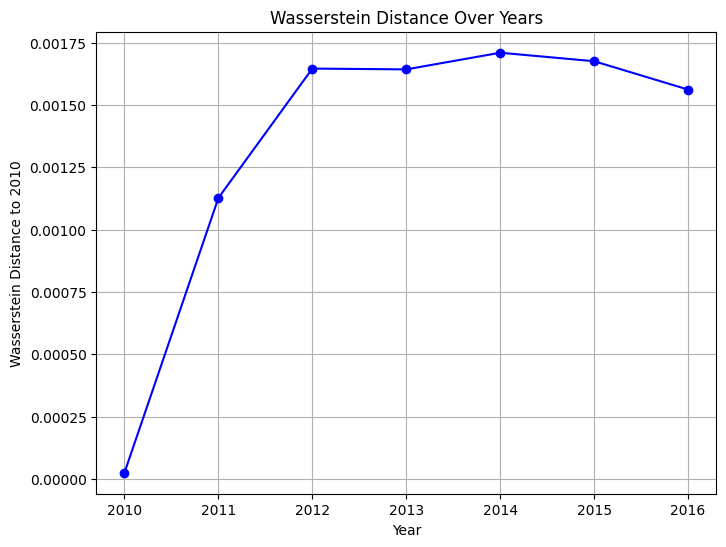

In [34]:
import ot
from tqdm import tqdm
from matplotlib import pyplot as plt

def sinkhorn_wasserstein2(X, Y, reg=0.1):
    if X.shape[0] != Y.shape[0]:
        N1 = X.shape[0]
        N2 = Y.shape[0]
        a = np.ones(N1) / N1  # uniform weights for X
        b = np.ones(N2) / N2  # uniform weights for Y
    else:
        N = X.shape[0]
        a = b = np.ones(N) / N  # uniform weights
        
    M = ot.dist(X, Y, metric='euclidean') ** 2
    transport_plan = ot.sinkhorn(a, b, M, reg)
    return np.sqrt(np.sum(transport_plan * M))


W_hat_2010 = np.load(f"usvt_C2/year2010_best_W.npy")
wasserstein_distances = [] #[0]
for year in tqdm(range(2010, 2017)):
    W_hat_t = np.load(f"usvt_C2/year{year}_best_W.npy")

    num_dim = min(W_hat_t.shape[1], W_hat_2010.shape[1]) 
    idx = np.random.choice(W_hat_t.shape[1], num_dim, replace=False)
    feature_1 = W_hat_t[:,idx]  # Random
    feature_2 = W_hat_2010  # Randomly selected features

    distance = sinkhorn_wasserstein2(feature_1, feature_2)
    wasserstein_distances.append(distance)

plt.figure(figsize=(8, 6))
plt.plot(np.arange(2010, 2017), wasserstein_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Wasserstein Distance to 2010')
plt.title('Wasserstein Distance Over Years')
plt.grid(True)
plt.show()

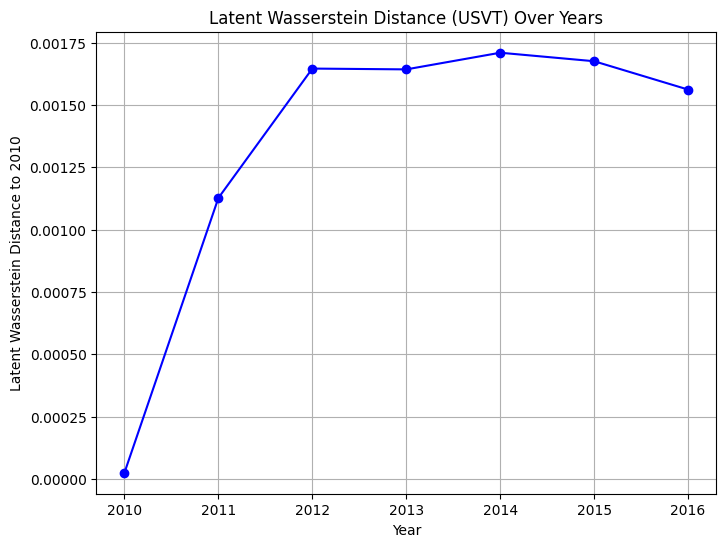

In [37]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(2010, 2017), wasserstein_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Latent Wasserstein Distance to 2010')
plt.title('Latent Wasserstein Distance (USVT) Over Years')
plt.grid(True)
plt.show()

In [35]:
from scipy.stats import pearsonr, spearmanr

pearsonr(np.array(wasserstein_distances), np.arange(2010,2017)), spearmanr(np.array(wasserstein_distances), np.arange(2010,2017))

(PearsonRResult(statistic=np.float64(0.7257183852166693), pvalue=np.float64(0.06485686748653446)),
 SignificanceResult(statistic=np.float64(0.5714285714285715), pvalue=np.float64(0.1802019889115274)))

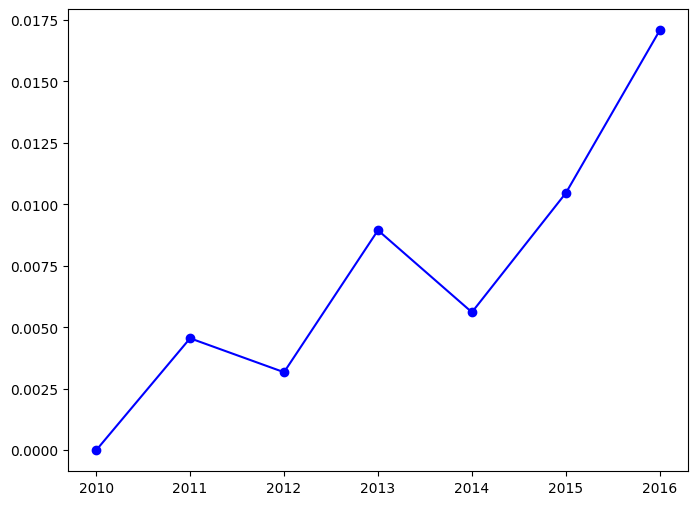

In [8]:
# USVT_arxiv_ogb_C2_v2.py
# USVT --> LP (energy=0.9) --> Sliced Wasserstein Distance (padding zero to align d )

import matplotlib.pyplot as plt
import numpy as np

wasserstein_distances = [0, 0.004554, 0.003174, 0.008946, 0.005613, 0.010460, 0.017078]

plt.figure(figsize=(8, 6))
plt.plot(np.arange(2010, 2017), wasserstein_distances, marker='o', linestyle='-', color='b')
plt.show()

In [9]:
from scipy.stats import pearsonr, spearmanr

pearsonr(np.array(wasserstein_distances), np.arange(2010,2017)), spearmanr(np.array(wasserstein_distances), np.arange(2010,2017))

(PearsonRResult(statistic=np.float64(0.900727970798721), pvalue=np.float64(0.005649692854214082)),
 SignificanceResult(statistic=np.float64(0.9285714285714288), pvalue=np.float64(0.0025194724037946874)))

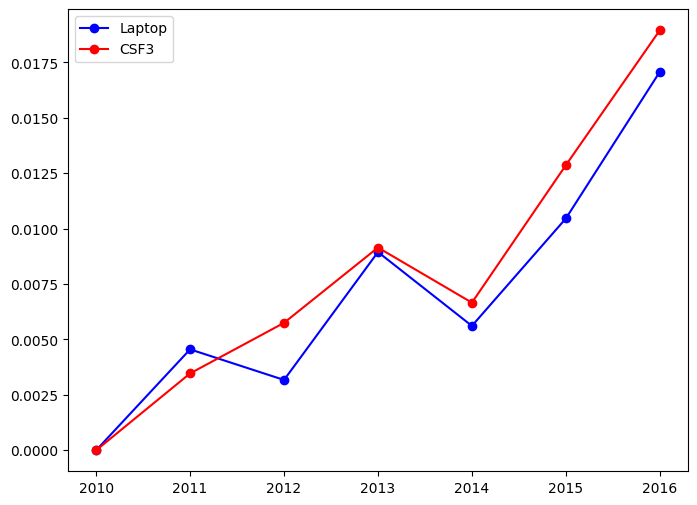

In [15]:
# USVT_arxiv_ogb_C2_v2.py
# USVT --> LP (energy=0.9) --> Sliced Wasserstein Distance (padding zero to align d )

import matplotlib.pyplot as plt
import numpy as np

wasserstein_distances_v2 = [0, 0.004554, 0.003174, 0.008946, 0.005613, 0.010460, 0.017078]
wasserstein_distances_v2_csf3 = [0, 0.003469, 0.005751, 0.009148, 0.006662, 0.012865, 0.018953]

plt.figure(figsize=(8, 6))
plt.plot(np.arange(2010, 2017), wasserstein_distances_v2, marker='o', linestyle='-', color='b', label='Laptop')
plt.plot(np.arange(2010, 2017), wasserstein_distances_v2_csf3, marker='o', linestyle='-', color='r', label='CSF3')
plt.legend()
plt.show()

In [16]:
from scipy.stats import pearsonr, spearmanr

pearsonr(np.array(wasserstein_distances_v2_csf3), np.arange(2010,2017)), spearmanr(np.array(wasserstein_distances_v2_csf3), np.arange(2010,2017))

(PearsonRResult(statistic=np.float64(0.9413841879549505), pvalue=np.float64(0.0015478013687296188)),
 SignificanceResult(statistic=np.float64(0.9642857142857145), pvalue=np.float64(0.0004541491691941689)))

In [22]:
pearsonr(np.array(wasserstein_distances_v2_csf3), np.array(wasserstein_distances_v2)), \
    spearmanr(np.array(wasserstein_distances_v2_csf3), np.array(wasserstein_distances_v2))

(PearsonRResult(statistic=np.float64(0.9797440727912813), pvalue=np.float64(0.00011094432699713328)),
 SignificanceResult(statistic=np.float64(0.9642857142857145), pvalue=np.float64(0.0004541491691941689)))

In [23]:
s = """2011: 1.982326
2012: 4.059180
2013: 5.596216
2014: 5.562897
2015: 2.782184
2016: 2.944951
2017: 6.044759
2018: 8.619743
2019: 8.970754
2020: 13.765508""".split('\n')

[float(w.split(': ')[1]) for w in s if ': ' in w]

[1.982326,
 4.05918,
 5.596216,
 5.562897,
 2.782184,
 2.944951,
 6.044759,
 8.619743,
 8.970754,
 13.765508]

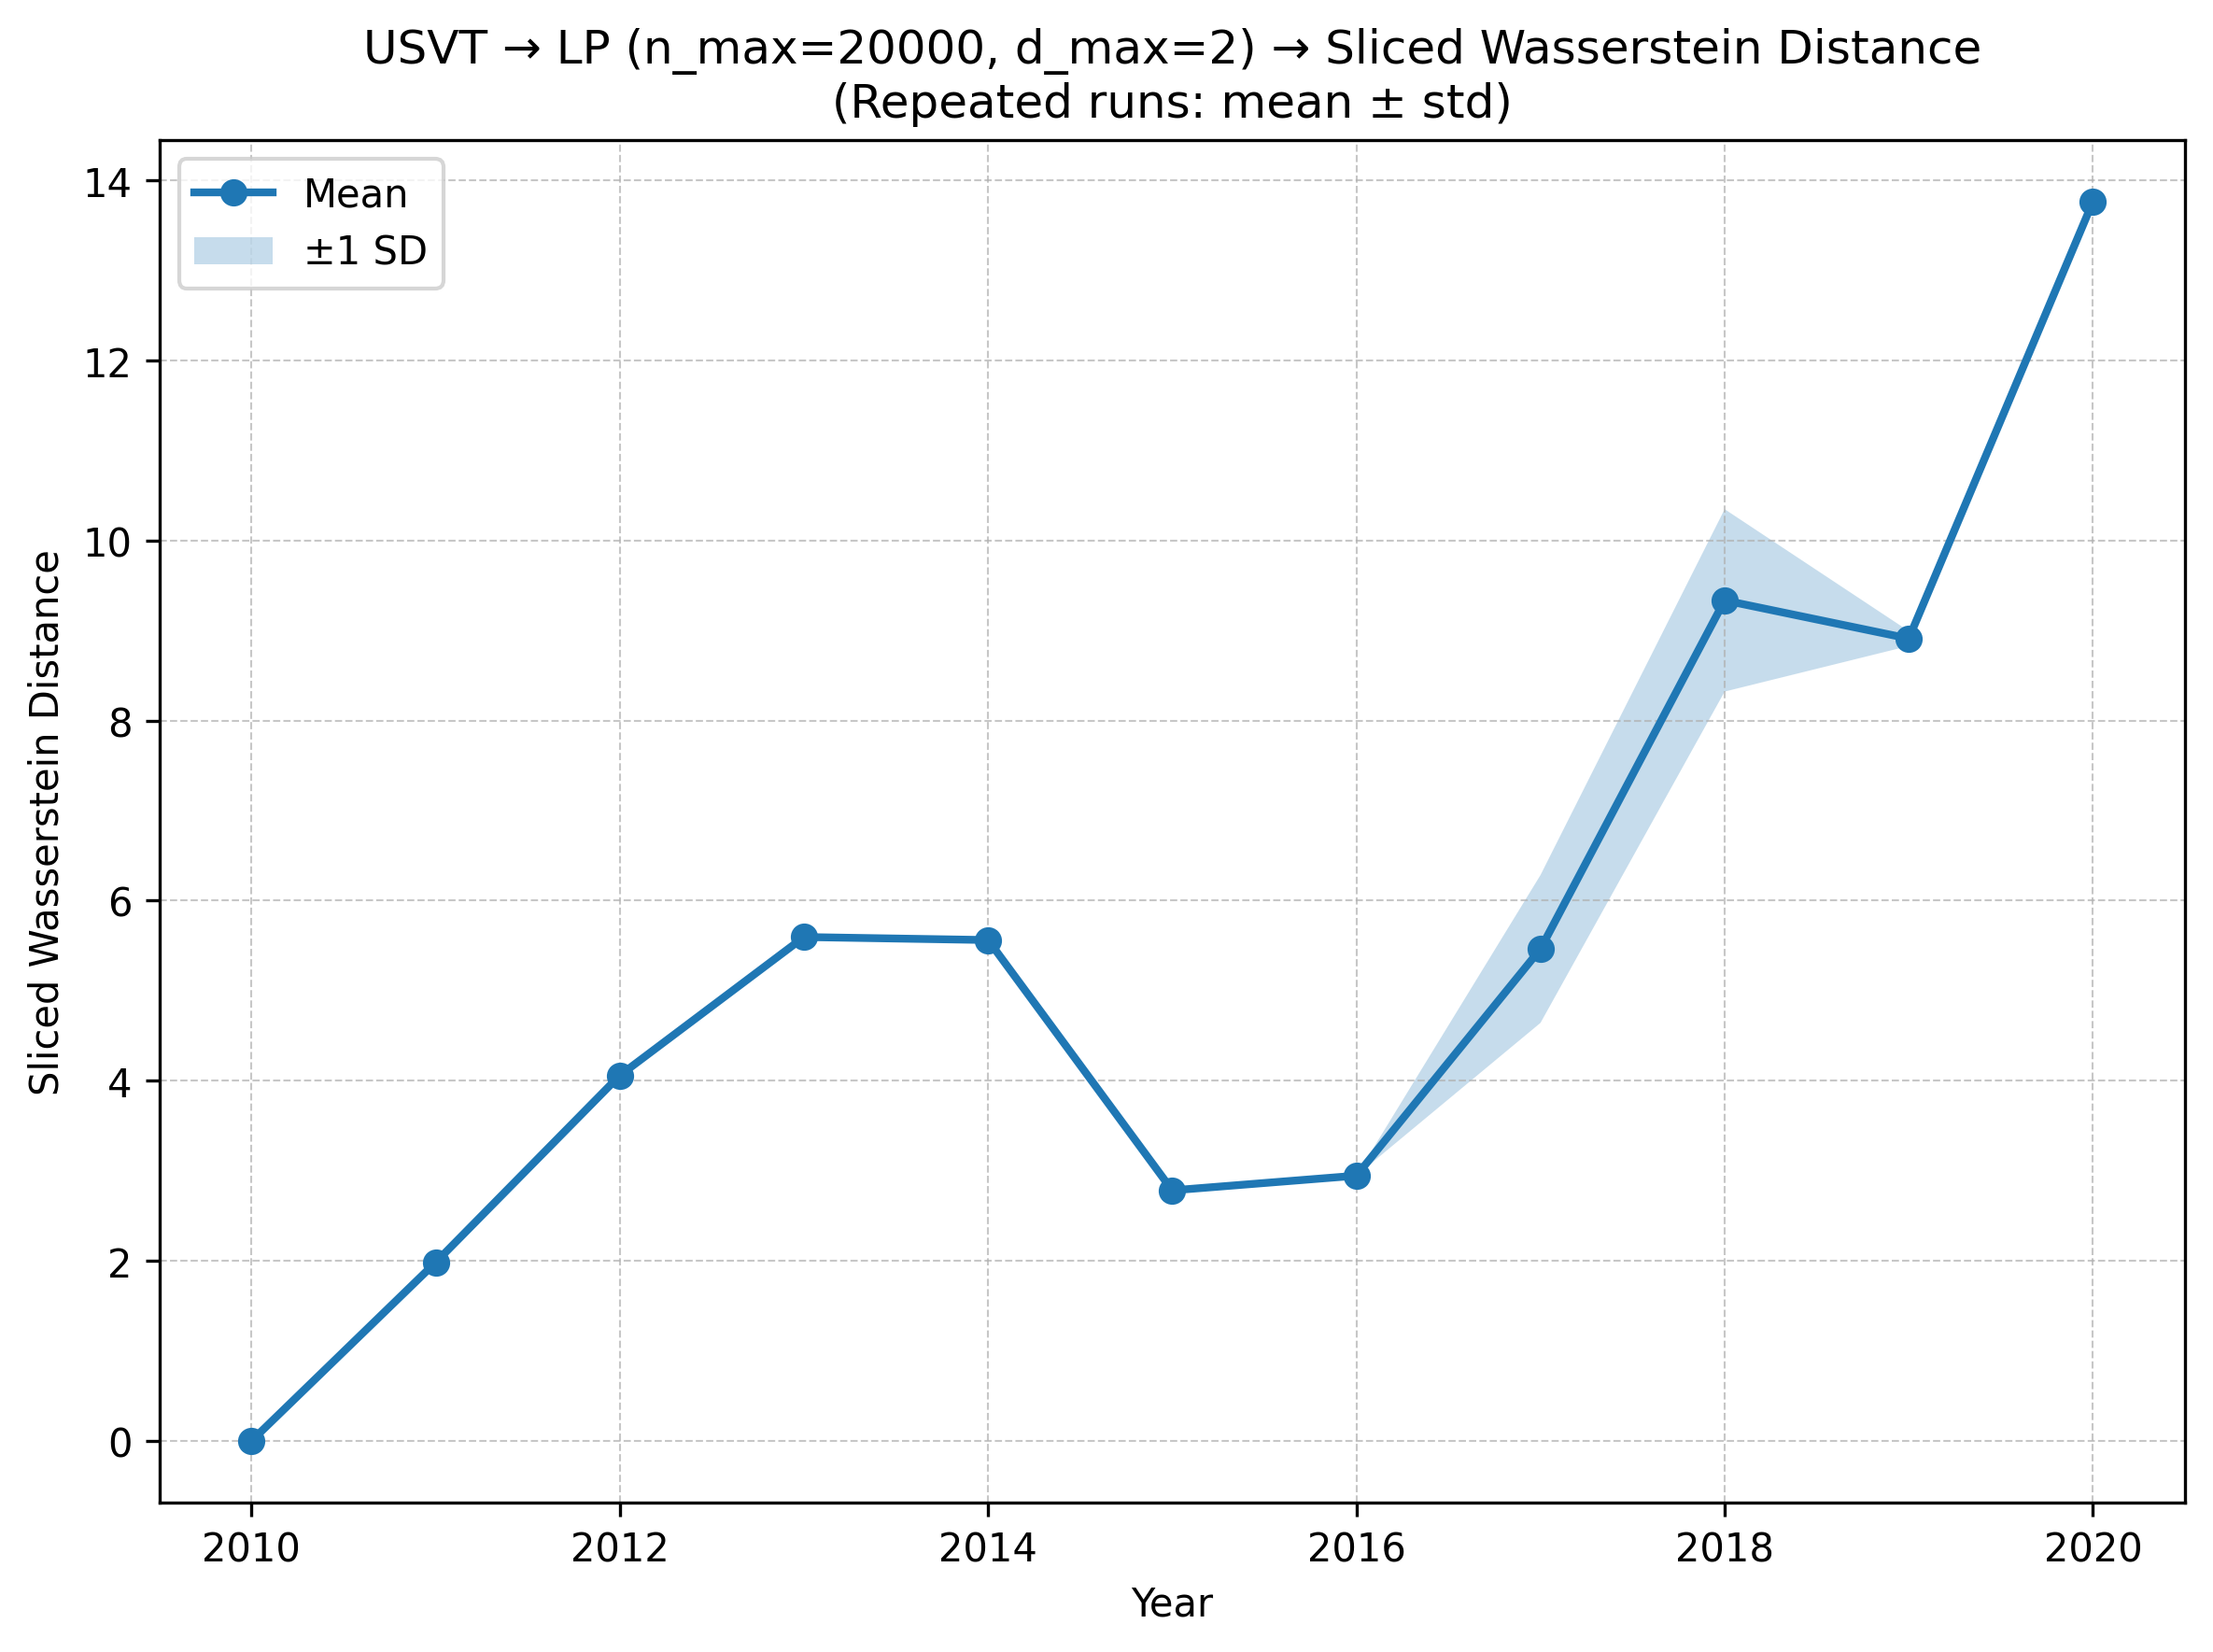

In [24]:
# Plot mean and standard deviation (shaded) for the repeated runs
import numpy as np
import matplotlib.pyplot as plt

# Data
years = np.arange(2010, 2021)

wasserstein_distances_v4_20K = np.array([0, 
                            1.982326,
                            4.05918,
                            5.596216,
                            5.562897,
                            2.782184,
                            2.944951,
                            4.302773,
                            10.76899,
                            8.79523,
                            13.765508])

wasserstein_distances_v4_20K_1 = np.array([0,
                                1.982326,
                                4.05918,
                                5.596216,
                                5.562897,
                                2.782184,
                                2.944951,
                                6.044759,
                                8.619743,
                                8.970754,
                                13.765508])

wasserstein_distances_v4_20K_2 = np.array([0,
                                1.982326,
                                4.05918,
                                5.596216,
                                5.562897,
                                2.782184,
                                2.944951,
                                6.044759,
                                8.619743,
                                8.970754,
                                13.765508])

runs = np.vstack([wasserstein_distances_v4_20K,
                  wasserstein_distances_v4_20K_1,
                  wasserstein_distances_v4_20K_2])

mean_vals = runs.mean(axis=0)
std_vals = runs.std(axis=0, ddof=0)

# Plot
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(years, mean_vals, marker='o', linewidth=2, label='Mean')
plt.fill_between(years, mean_vals - std_vals, mean_vals + std_vals, alpha=0.25, label='±1 SD')
plt.xlabel('Year')
plt.ylabel('Sliced Wasserstein Distance')
plt.title('USVT → LP (n_max=20000, d_max=2) → Sliced Wasserstein Distance\n(Repeated runs: mean ± std)')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()
plt.tight_layout()

# Save the figure for download
# out_path = '/mnt/data/wasserstein_std_plot.png'
# plt.savefig(out_path, dpi=200, bbox_inches='tight')
# out_path


In [18]:
from scipy.stats import pearsonr, spearmanr

pearsonr(np.array(wasserstein_distances_v3), np.arange(2010,2017)), spearmanr(np.array(wasserstein_distances_v3), np.arange(2010,2017))

(PearsonRResult(statistic=np.float64(0.8326449003254428), pvalue=np.float64(0.020066007051884154)),
 SignificanceResult(statistic=np.float64(0.8214285714285715), pvalue=np.float64(0.023448808345691505)))

In [21]:
pearsonr(np.array(wasserstein_distances_v3), np.array(wasserstein_distances_v2_csf3)), \
    spearmanr(np.array(wasserstein_distances_v3), np.array(wasserstein_distances_v2_csf3))

(PearsonRResult(statistic=np.float64(0.797214002087346), pvalue=np.float64(0.03178054257769534)),
 SignificanceResult(statistic=np.float64(0.7142857142857144), pvalue=np.float64(0.07134356146753759)))

# 3. variational inference

In [16]:
sub_data

Data(num_nodes=12035, edge_index=[2, 8125], x=[12035, 128], node_year=[12035, 1], y=[12035, 1])

In [13]:
class LatentPositionModel:
    def __init__(self, N, d):
        self.N = N
        self.d = d
        self.mu = torch.randn(N, d, requires_grad=True)  # Latent means
        self.log_sigma = torch.randn(N, d, requires_grad=True)  # Log of std dev to ensure positivity

    def get_variational_params(self):
        sigma = torch.exp(self.log_sigma)  # Convert log std dev to std dev
        return self.mu, sigma

    def likelihood(self, A, mu, sigma):
        """Compute the log-likelihood for the observed adjacency matrix A."""
        log_p = 0
        for i in range(self.N):
            for j in range(i + 1, self.N):  # Only upper triangle for undirected graph
                dist = torch.norm(mu[i] - mu[j])  # Euclidean distance between latent positions
                p_ij = torch.sigmoid(-dist**2)
                log_p += A[i, j] * torch.log(p_ij) + (1 - A[i, j]) * torch.log(1 - p_ij)
        return log_p

    def kl_divergence(self, mu, sigma):
        """Compute the KL divergence between the variational distribution and the prior."""
        kl = 0
        for i in range(self.N):
            kl += 0.5 * torch.sum(sigma[i]**2 + mu[i]**2 - torch.log(sigma[i]) - 1)  # Closed-form KL for Gaussian prior
        return kl

    def elbo(self, A):
        """Compute the Evidence Lower Bound (ELBO)."""
        mu, sigma = self.get_variational_params()
        log_likelihood = self.likelihood(A, mu, sigma)
        kl = self.kl_divergence(mu, sigma)
        return log_likelihood - kl


In [14]:
def optimize_lpm(A, d=2, lr=0.01, num_epochs=1000):
    model = LatentPositionModel(N=A.shape[0], d=d)
    optimizer = torch.optim.Adam([model.mu, model.log_sigma], lr=lr)

    # Optimize for the ELBO
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        elbo = model.elbo(A)
        elbo.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, ELBO: {elbo.item()}')

    # After optimization, return the learned latent positions
    mu, _ = model.get_variational_params()
    return mu

In [22]:
from torch_geometric.utils import subgraph, to_scipy_sparse_matrix

# A = to_scipy_sparse_matrix(sub_data.edge_index, num_nodes=sub_data.num_nodes).astype(np.float64)

A = torch.zeros((sub_data.num_nodes, sub_data.num_nodes), dtype=torch.float)
A[sub_data.edge_index[0], sub_data.edge_index[1]] = 1
type(A), A.dtype, A.shape

(torch.Tensor, torch.float32, torch.Size([12035, 12035]))

In [24]:
# # Run the optimization
# learned_latent_positions = optimize_lpm(A, d=2)
# print("Learned Latent Positions:")
# print(learned_latent_positions)

In [ ]:
from tqdm import tqdm

d=2
lr=0.001
num_epochs=1000

model = LatentPositionModel(N=A.shape[0], d=d)
optimizer = torch.optim.Adam([model.mu, model.log_sigma], lr=lr)

# Optimize for the ELBO
for epoch in tqdm(range(num_epochs), desc="Training ELBO"):
    optimizer.zero_grad()
    elbo = model.elbo(A)
    elbo.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, ELBO: {elbo.item()}')

# After optimization, return the learned latent positions
mu, _ = model.get_variational_params()

Training ELBO:   0%|          | 0/1000 [00:00<?, ?it/s]